In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import re
from collections import Counter

# VEST OH 2020
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Ohio Secretary of State (https://www.sos.state.oh.us/elections/election-results-and-data/). 

#### Processing Part 1
The following counties include adjustments to account for corporate annexations that are not specified below by precinct: Adams, Athens, Butler, Franklin, Guernsey, Montgomery, Stark, Tuscarawas, Warren, Wayne.

#### Processing Part 2 (unclear whether this is for election results, shapefiles, or both)
The following additional revisions were made to match the 2020 precinct boundaries:

- **Athens:** Adjust Athens 4-4/4-5, Nelsonville 1/2/3/4
- **Brown:** Adjust Perry Twp South/Villages
- **Butler:** Adjust Hamilton 22/24, Oxford 6/11, Trenton 5/7, West Chester 28/39
- **Champaign:** Adjust Union N/S
- **Clark:** Align New Carlisle, Springfield precincts with county maps
- **Crawford:** Move eastern Polk Twp from Galion 1B to western Polk Twp
- **Cuyahoga:** Adjust Olmsted Twp D/F/H
- **Delaware:** Adjust Berlin C/Delaware 3-F
- **Fairfield:** Adjust Greenfield B/Lancaster 2-A, Pickerington F/Violet B/Violet C
- **Greene:** Adjust Bath 277/Fairborn 226/Xenia 351
- **Hamilton:** Adjust Cleves A/Whitewater A, Colerain BB/F
- **Knox:** Adjust Clinton A/Mount Vernon 1-B, Clinton B/Mount Vernon 2-A
- **Lake:** Adjust Painesville A/K
- **Medina:** Adjust Wadsworth City 1-D/Sharon D, Wadsworth City 2-D/Twp C
- **Richland:** Adjust Ontario 3/4
- **Stark:** Adjust Canton 8-C/Plain 6, Canton 6-A/Plain 12
- **Summit:** Adjust Coventry D/G, Hudson 1-B/3-C, Springfield F/J
- **Warren:** Adjust Mason City Z/Union A, South Lebanon A/B

#### Races
G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREGHAW - Howie Hawkins (Independent)  

### Shapefiles

#### Sources
Precinct shapefile from the U.S. Census Bureau's 2020 Redistricting Data Program final release. Note that some VTDs were relabeled to match precinct names and/or precinct codes in the November 2020 general election returns.

# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_oh_20 = gp.read_file("./raw-from-source/VEST/oh_2020/oh_2020.shp")

In [3]:
vest_oh_20.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

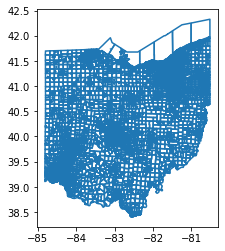

In [4]:
vest_oh_20.boundary.plot()

In [5]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry'],
      dtype='object')

### Create a FIPs dictionary for OH

In [6]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Ohio"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
oh_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Load and Clean Election Results

### Load Election Results

Cleaned the `statewideresultsbyprecinct.xlsx` file by hand, and created `statewideresultsbyprecinct_clean.csv`. No modifications were made to the election results. Unnecessary tabs were removed and column names were renamed to match VEST's manually. 

In [7]:
#Load in clean SOS file
elections_2020_raw = pd.read_excel("./raw-from-source/SOS/statewideresultsbyprecinct.xlsx",sheet_name="Master")

In [8]:
def clean_oh_import(dataframe):
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col_name = dataframe.columns[index]
        col_name = col_name.replace("\n"," ")
        if "Unnamed" in col_name:
            corrected_col_names.append(corrected_col_names[index-1])
        else:
            corrected_col_names.append(col_name)
    dataframe.columns = corrected_col_names
    
    corrected_col_names = []
    for index in range(0,len(dataframe.columns)):
        col = dataframe.columns[index]
        first_row = dataframe.iloc[0,index]
        if (index > 7):
            new_column_name = col + " " + first_row 
            corrected_col_names.append(new_column_name)
        else:
            corrected_col_names.append(first_row)
    dataframe.columns = corrected_col_names
    
    dataframe = dataframe.iloc[3:,]
    return dataframe

In [9]:
elections_2020 = clean_oh_import(elections_2020_raw)

In [10]:
elections_2020["COUNTYFP"] = elections_2020['County Name'].map(oh_fips_dict).fillna("n/a")

<ipython-input-10-d74292b25e12>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  elections_2020["COUNTYFP"] = elections_2020['County Name'].map(oh_fips_dict).fillna("n/a")


In [11]:


filter_out_cols = [i for i in elections_2020.columns if ("Judge of the Court of Appeals - District" in i or "Member of the State Board of Education - District" in i or "WI" in i)]

In [12]:
elections_2020 = elections_2020[[i for i in elections_2020.columns if i not in filter_out_cols]]

## Look into split precincts

In [13]:
def get_level_dist(column_name):
    if "Representative to Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
    else:
        raise ValueError
    return_val = re.findall("District \S{2}",column_name)    
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
    else:
        raise ValueError
    return level,dist

In [14]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [15]:
district_cols = [i for i in elections_2020.columns if "District" in i]
elections_2020_districts = elections_2020[['COUNTYFP','Precinct Name','Precinct Code']+district_cols]

In [16]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in elections_2020_districts.iterrows():
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            precinct_info = get_level_dist(contest)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["COUNTYFP"]+"-"+row["Precinct Code"]]=is_split
    precinct_mapping_dict[row["COUNTYFP"]+"-"+row["Precinct Code"]]=precinct_list


In [17]:
split_precincts_list

{'011-AAR': {'SL': ['82', '84']},
 '017-ACG': {'SL': ['51', '53']},
 '017-AGC': {'SL': ['51', '53']},
 '017-AGH': {'SL': ['51', '53']},
 '017-AIF': {'SL': ['51', '53']},
 '035-AEI': {'CON': ['09', '16']},
 '035-AHU': {'SL': ['09', '12']},
 '035-ALT': {'SL': ['09', '11']},
 '035-AWR': {'SL': ['08', '10']},
 '035-AZU': {'SL': ['10', '13']},
 '035-BBR': {'SL': ['10', '15']},
 '035-BCI': {'SL': ['13', '15']},
 '035-BCZ': {'SL': ['10', '15']},
 '035-BEH': {'CON': ['09', '11']},
 '035-BFB': {'CON': ['09', '11']},
 '035-BFK': {'CON': ['09', '11']},
 '041-AEH': {'SL': ['67', '68']},
 '041-AEM': {'SL': ['67', '68']},
 '041-AFW': {'SL': ['67', '68']},
 '043-ACF': {'CON': ['04', '09']},
 '045-ACF': {'SL': ['77', '78']},
 '047-AAU': {'CON': ['10', '15']},
 '047-ABK': {'CON': ['10', '15']},
 '049-AAO': {'CON': ['03', '15'], 'SL': ['17', '18']},
 '049-AAS': {'CON': ['03', '15']},
 '049-ABL': {'SL': ['18', '25']},
 '049-ABX': {'CON': ['03', '15']},
 '049-ABY': {'CON': ['03', '15']},
 '049-ABZ': {'CON

In [18]:
precinct_mapping_dict

{'001-AAA': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAB': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAD': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAE': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAG': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAI': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAK': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAN': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAP': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAR': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAS': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAT': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAU': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAW': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAY': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-AAZ': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-ABA': [('CON', '02'), ('SU', '14'), ('SL', '90')],
 '001-ABC': [('CON', '02'), ('S

## Rename Columns

In [19]:
elections_2020.columns

keep_names = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','COUNTYFP']

In [20]:
def get_race(contest):
    if "Justice of the Supreme Court" in contest:
        level = "SSC"
        if "Kennedy" in contest or "O'Donnell" in contest:
            level = "SSCK"
        else:
            level = "SSCF"
    elif "President" in contest:
        level = "PRE"
    elif ("Representative to Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]
    else:
          raise ValueError
    return level

"Although elections for the Ohio Supreme Court are officially nonpartisan, they are preceded by a partisan primary."

In [21]:
def get_party(contest):
    if contest == "State Representative - District 30  Tom Roll":
        return "I"
    if "Justice of the Supreme Court Term" in contest:
        if "Sharon L. Kennedy" in contest:
            return "R"
        elif "John P. O'Donnell" in contest:
            return "D"
        elif "Jennifer Brunner" in contest:
            return "D"
        elif "Judi French" in contest:
            return "R"
        else:
            print(contest)
            raise ValueError
    return_val = re.findall("\(\S\)",contest)   
    if (len(return_val)!=0):
        party = return_val[0][1]
        return party
    else:
        print(contest)
        raise ValueError

In [22]:
def get_name(contest):
    contest = contest.upper()
    contest = contest.replace("'","")
    if ("(") in contest.split(" ")[-1]:
        second_to_last = contest.split(" ")[-2]
        #second_to_last = second_to_last.replace("'","")
        if second_to_last in ["JR","III"]:
            third_to_last = contest.split(" ")[-3]
            #third_to_last = third_to_last.replace("'","")
            return third_to_last[0:3]
        else:
            return second_to_last[0:3]
    else:
        return contest.split(" ")[-1][0:3] 

In [23]:
contest_name_change_dict = {
 'President and Vice President  Joseph R. Biden and Kamala D. Harris (D)':'G20PREDBID',
 'President and Vice President  Howie Hawkins and Angela Walker':'G20PREGHAW',
 'President and Vice President  Jo Jorgensen and Spike Cohen (L)':'G20PRELJOR',
 'President and Vice President  Donald J. Trump and Michael R. Pence (R)':'G20PRERTRU',
}

In [24]:
for contest in elections_2020.columns:
    if contest not in keep_names and "President" not in contest:
        contest_name_change_dict[contest] = "G"+get_race(contest)+get_party(contest)+get_name(contest)

In [25]:
elections_2020.rename(columns=contest_name_change_dict,inplace=True)

In [26]:
df = pd.DataFrame([(v, k) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
df.to_csv('./cand_dicts/oh_gen_20_sldl_prec.csv', sep=',')

In [27]:
list(elections_2020.columns)

['County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Ballots Counted',
 'Official Voter Turnout',
 'G20PREDBID',
 'G20PREGHAW',
 'G20PRELJOR',
 'G20PRERTRU',
 'GCON01RCHA',
 'GCON01LKAH',
 'GCON01DSCH',
 'GCON02DCAS',
 'GCON02RWEN',
 'GCON03DBEA',
 'GCON03RRIC',
 'GCON04DFRE',
 'GCON04RJOR',
 'GCON04LPER',
 'GCON05RLAT',
 'GCON05DRUB',
 'GCON06RJOH',
 'GCON06DROB',
 'GCON07RGIB',
 'GCON07LLAP',
 'GCON07DPOT',
 'GCON08RDAV',
 'GCON08DENO',
 'GCON09DKAP',
 'GCON09RWEB',
 'GCON10DTIM',
 'GCON10RTUR',
 'GCON11DFUD',
 'GCON11RGOR',
 'GCON12RBAL',
 'GCON12DSHE',
 'GCON12LSTE',
 'GCON13LFRI',
 'GCON13RHAG',
 'GCON13DRYA',
 'GCON14RJOY',
 'GCON14DMUE',
 'GCON15DNEW',
 'GCON15RSTI',
 'GCON16DGOD',
 'GCON16RGON',
 'GSU02RGAV',
 'GSU02DODO',
 'GSU04RLAN',
 'GSU04DWYE',
 'GSU06RANT',
 'GSU06DFOG',
 'GSU08RBLE',
 'GSU08DBRO',
 'GSU10DBAL',
 'GSU10RHAC',
 'GSU12RHUF',
 'GSU12DPOL',
 'GSU14RJOH',
 'GSU14DOTT',
 'GSU16RKUN',
 'GSU16DLET',
 'GSU18

### Filter Down to Relevant Columns

In [28]:
keeper_columns = ['County Name','Precinct Name','Precinct Code','Region Name','Media Market','Registered Voters','Ballots Counted','Official Voter Turnout','COUNTYFP']
state_house_contests = [i for i in list(elections_2020.columns) if "GSL" in i]

In [29]:
elections_2020 = elections_2020[keeper_columns+state_house_contests]

### Compare Precinct Totals

In [30]:
elections_2020["UNIQUE_ID"] = elections_2020["COUNTYFP"]+"-"+elections_2020["Precinct Code"]
vest_oh_20["UNIQUE_ID"] = vest_oh_20["COUNTYFP20"]+"-"+vest_oh_20["PRECINCT20"]

In [31]:
#Confirm unique IDs are unique
print(elections_2020["UNIQUE_ID"].value_counts(dropna=False))
print(vest_oh_20["UNIQUE_ID"].value_counts(dropna=False))

093-ABB    1
035-BGE    1
035-BSY    1
035-CYQ    1
091-ABH    1
          ..
153-ARI    1
155-AJM    1
017-AFW    1
017-AKP    1
099-AAW    1
Name: UNIQUE_ID, Length: 8933, dtype: int64
057-AHA    1
003-AGK    1
035-CZS    1
009-ABN    1
095-ALG    1
          ..
119-ACX    1
105-AAE    1
081-ADW    1
017-AGG    1
099-AAW    1
Name: UNIQUE_ID, Length: 8941, dtype: int64


In [32]:
global attempt_one
attempt_one = pd.merge(vest_oh_20,elections_2020,how="outer",on="UNIQUE_ID",indicator=True)
print(attempt_one["_merge"].value_counts())

vest_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only = attempt_one[attempt_one["_merge"]=="right_only"]

both          8933
left_only        8
right_only       0
Name: _merge, dtype: int64


In [33]:
#Confirm these are all zero-vote races
races =["UNIQUE_ID"]

for val in ['G20PRERTRU', 'G20PREDBID', 'G20PRELJOR','G20PREGHAW']:
    races.append(val)

print((vest_only[races]))

     UNIQUE_ID  G20PRERTRU  G20PREDBID  G20PRELJOR  G20PREGHAW
814    093-ZZZ           0           0           0           0
982    123-ZZZ           0           0           0           0
2924   095-ZZZ           0           0           0           0
3674   043-ZZZ           0           0           0           0
4389   085-ZZZ           0           0           0           0
4565   035-ZZZ           0           0           0           0
5357   133-ZZZ           0           0           0           0
7951   007-ZZZ           0           0           0           0


## Perform Splits

In [34]:
def return_sll_splits(split_dict):
    for val in split_dict.keys():
        if 'SLL' in val:
            return split_dict['SLL']

In [35]:
sll_splits_dict = {i:return_sll_splits(split_precincts_list[i]) for i in split_precincts_list.keys() if return_sll_splits(split_precincts_list[i]) != None }

In [36]:
sll_splits_dict

{}

#### Load in the shapefile

In [37]:
oh_sll_districts = gp.read_file("./raw-from-source/District_Shapefiles/cb_2018_39_sldl_500k/cb_2018_39_sldl_500k.shp")

In [38]:
oh_sll_districts = oh_sll_districts.to_crs(vest_oh_20.crs)
oh_sll_districts["SLDLST"] = oh_sll_districts["SLDLST"].str[1:3]

In [39]:
list(attempt_one.columns)

['STATEFP20',
 'COUNTYFP20',
 'VTDST20',
 'PRECINCT20',
 'GEOID20',
 'NAME20',
 'G20PRERTRU',
 'G20PREDBID',
 'G20PRELJOR',
 'G20PREGHAW',
 'geometry',
 'UNIQUE_ID',
 'County Name',
 'Precinct Name',
 'Precinct Code',
 'Region Name',
 'Media Market',
 'Registered Voters',
 'Ballots Counted',
 'Official Voter Turnout',
 'COUNTYFP',
 'GSL01DTHE',
 'GSL01RWIG',
 'GSL02DGRA',
 'GSL02RJOH',
 'GSL03RGHA',
 'GSL03DJOH',
 'GSL04RCUP',
 'GSL05RGIN',
 'GSL05DWIN',
 'GSL06RHAW',
 'GSL06DROB',
 'GSL07RPAT',
 'GSL07DSWE',
 'GSL08DSMI',
 'GSL09DBOY',
 'GSL09RRUS',
 'GSL10DUPC',
 'GSL11DHOW',
 'GSL12DBRE',
 'GSL12RPOW',
 'GSL13RHAR',
 'GSL13DSKI',
 'GSL14RMCM',
 'GSL14DSWE',
 'GSL15DCRO',
 'GSL15RKUS',
 'GSL16RGRE',
 'GSL16DSMI',
 'GSL17RHAS',
 'GSL17DMIL',
 'GSL18DBOG',
 'GSL18RPAC',
 'GSL19RFRE',
 'GSL19DLIG',
 'GSL20RBAE',
 'GSL20DBRO',
 'GSL21RCOO',
 'GSL21DLIS',
 'GSL22DLEL',
 'GSL23DDAY',
 'GSL23RLAN',
 'GSL24RMAN',
 'GSL24DRUS',
 'GSL25RBUR',
 'GSL25DJAR',
 'GSL26DCRA',
 'GSL27DBIT',
 'GSL27RB

In [40]:
final_races = ['GSL01DTHE',
 'GSL01RWIG',
 'GSL02DGRA',
 'GSL02RJOH',
 'GSL03RGHA',
 'GSL03DJOH',
 'GSL04RCUP',
 'GSL05RGIN',
 'GSL05DWIN',
 'GSL06RHAW',
 'GSL06DROB',
 'GSL07RPAT',
 'GSL07DSWE',
 'GSL08DSMI',
 'GSL09DBOY',
 'GSL09RRUS',
 'GSL10DUPC',
 'GSL11DHOW',
 'GSL12DBRE',
 'GSL12RPOW',
 'GSL13RHAR',
 'GSL13DSKI',
 'GSL14RMCM',
 'GSL14DSWE',
 'GSL15DCRO',
 'GSL15RKUS',
 'GSL16RGRE',
 'GSL16DSMI',
 'GSL17RHAS',
 'GSL17DMIL',
 'GSL18DBOG',
 'GSL18RPAC',
 'GSL19RFRE',
 'GSL19DLIG',
 'GSL20RBAE',
 'GSL20DBRO',
 'GSL21RCOO',
 'GSL21DLIS',
 'GSL22DLEL',
 'GSL23DDAY',
 'GSL23RLAN',
 'GSL24RMAN',
 'GSL24DRUS',
 'GSL25RBUR',
 'GSL25DJAR',
 'GSL26DCRA',
 'GSL27DBIT',
 'GSL27RBRI',
 'GSL28DMIR',
 'GSL28RMON',
 'GSL29RABR',
 'GSL30IROL',
 'GSL30RSEI',
 'GSL31DKEL',
 'GSL32DING',
 'GSL33DDEN',
 'GSL33RHIL',
 'GSL34DSYK',
 'GSL34RTOD',
 'GSL35DGAL',
 'GSL35RSAR',
 'GSL36DSHA',
 'GSL36RYOU',
 'GSL37RBIG',
 'GSL37DWEI',
 'GSL38DCAM',
 'GSL38RROE',
 'GSL39DBLA',
 'GSL39RMUL',
 'GSL40DJAC',
 'GSL40RPLU',
 'GSL41DBER',
 'GSL41RWHI',
 'GSL42RYOU',
 'GSL43DCOX',
 'GSL43RCRE',
 'GSL44DHIC',
 'GSL44RMCM',
 'GSL45RLOG',
 'GSL45DSOB',
 'GSL46RSAL',
 'GSL46DSHE',
 'GSL47DLAR',
 'GSL47RMER',
 'GSL48ROEL',
 'GSL49RHAA',
 'GSL49DWES',
 'GSL50DSIM',
 'GSL50RSTO',
 'GSL51RCAR',
 'GSL52RGRO',
 'GSL52DHOR',
 'GSL53RHAL',
 'GSL53DNOV',
 'GSL54DSHO',
 'GSL54RZEL',
 'GSL55RMAN',
 'GSL55DSTE',
 'GSL56RLAC',
 'GSL56DMIL',
 'GSL57DADK',
 'GSL57RSTE',
 'GSL58DHAG',
 'GSL58RSIM',
 'GSL59RCUT',
 'GSL59DSTA',
 'GSL60RPHI',
 'GSL60DTRO',
 'GSL61RCAL',
 'GSL61DDUD',
 'GSL62RLIP',
 'GSL62DROS',
 'GSL63DBLA',
 'GSL63RLOY',
 'GSL64DOBR',
 'GSL64RYOD',
 'GSL65DDAR',
 'GSL65RSCH',
 'GSL66RBIR',
 'GSL67RJOR',
 'GSL67DMOR',
 'GSL68RCAR',
 'GSL68DMOU',
 'GSL69DBEH',
 'GSL69RRAY',
 'GSL70DBAR',
 'GSL70RKIC',
 'GSL71DCAR',
 'GSL71RFRA',
 'GSL72RHOU',
 'GSL73RLAM',
 'GSL73DMCC',
 'GSL74RDEA',
 'GSL75DCLI',
 'GSL75RPAV',
 'GSL76RGRE',
 'GSL76DWES',
 'GSL77RLAR',
 'GSL77DWIL',
 'GSL78DOWE',
 'GSL78RSTE',
 'GSL79RKOE',
 'GSL79DRIC',
 'GSL80DJON',
 'GSL80RPOW',
 'GSL81RHOO',
 'GSL82RRIE',
 'GSL83RCRO',
 'GSL84RMAN',
 'GSL84DMON',
 'GSL85RVIT',
 'GSL86RRIC',
 'GSL86DROB',
 'GSL87DBAR',
 'GSL87RMCC',
 'GSL88RCLI',
 'GSL88DLIE',
 'GSL89DMIL',
 'GSL89RSWE',
 'GSL90RBAL',
 'GSL91DDAI',
 'GSL91RWIL',
 'GSL92RJOH',
 'GSL92DWOR',
 'GSL93RSTE',
 'GSL94REDW',
 'GSL94DONE',
 'GSL95RJON',
 'GSL96RFER',
 'GSL96LHER',
 'GSL96DOLI',
 'GSL97RHOL',
 'GSL97DSWO',
 'GSL98DBEE',
 'GSL98RHIL',
 'GSL99DDAN',
 'GSL99RART']

In [41]:
for val in final_races:
    attempt_one[val] = attempt_one[val].fillna(0)
    attempt_one[val] = attempt_one[val].astype(int)
    print(val, sum(attempt_one[val]))

GSL01DTHE 15836
GSL01RWIG 36730
GSL02DGRA 16440
GSL02RJOH 41102
GSL03RGHA 37677
GSL03DJOH 27094
GSL04RCUP 38882
GSL05RGIN 36243
GSL05DWIN 12554
GSL06RHAW 35982
GSL06DROB 37995
GSL07RPAT 37493
GSL07DSWE 26922
GSL08DSMI 41159
GSL09DBOY 50894
GSL09RRUS 7868
GSL10DUPC 28453
GSL11DHOW 27346
GSL12DBRE 43247
GSL12RPOW 9342
GSL13RHAR 11621
GSL13DSKI 33647
GSL14RMCM 19643
GSL14DSWE 27618
GSL15DCRO 24020
GSL15RKUS 22018
GSL16RGRE 34075
GSL16DSMI 35013
GSL17RHAS 16588
GSL17DMIL 21664
GSL18DBOG 45861
GSL18RPAC 13007
GSL19RFRE 32950
GSL19DLIG 42267
GSL20RBAE 24928
GSL20DBRO 36330
GSL21RCOO 32756
GSL21DLIS 42990
GSL22DLEL 45754
GSL23DDAY 27532
GSL23RLAN 34275
GSL24RMAN 31202
GSL24DRUS 42935
GSL25RBUR 8870
GSL25DJAR 41312
GSL26DCRA 45350
GSL27DBIT 33339
GSL27RBRI 37723
GSL28DMIR 35353
GSL28RMON 33039
GSL29RABR 43320
GSL30IROL 16426
GSL30RSEI 42269
GSL31DKEL 42180
GSL32DING 42055
GSL33DDEN 41500
GSL33RHIL 13901
GSL34DSYK 36251
GSL34RTOD 10926
GSL35DGAL 22341
GSL35RSAR 17210
GSL36DSHA 29441
GSL36RYOU 3

In [42]:
def cd_splits(cd_list,level,old_name):
    global attempt_one
    full_shape = attempt_one.loc[attempt_one["UNIQUE_ID"]==old_name]
    #print(old_name,"->"," & ".join(new_id_list))
    for index in range(0,len(cd_list)):
        cd = oh_sll_districts.loc[oh_sll_districts["SLDLST"]==cd_list[index]]
        new_prec = gp.overlay(full_shape, cd, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging SLDL: ",cd_list[index],"and prec:",old_name,"***")
        new_prec = new_prec[list(attempt_one.columns)]
        for column in new_prec:
            if column in final_races and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec["UNIQUE_ID"]=old_name+"-("+level+"-"+cd_list[index]+")"
        attempt_one=attempt_one.append(new_prec)
        attempt_one.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    attempt_one=attempt_one[attempt_one["UNIQUE_ID"]!=old_name]
    attempt_one.reset_index(drop=True,inplace=True)

In [43]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in attempt_one["UNIQUE_ID"]:
    cd_list = []
    if val in sll_splits_dict.keys():
        print(val)
        print(sll_splits_dict[val])
        #How we will actually call it
        cd_splits(sll_splits_dict[val],"SLL",val)

In [44]:
pd.options.display.max_columns = 999

display(attempt_one[attempt_one["UNIQUE_ID"]=="049-BBR-(SLL-19)"])
display(attempt_one[attempt_one["UNIQUE_ID"]=="049-BBR-(SLL-21)"])
display(attempt_one[attempt_one["UNIQUE_ID"]=="049-BBR-(SLL-22)"])

Empty GeoDataFrame
Columns: [STATEFP20, COUNTYFP20, VTDST20, PRECINCT20, GEOID20, NAME20, G20PRERTRU, G20PREDBID, G20PRELJOR, G20PREGHAW, geometry, UNIQUE_ID, County Name, Precinct Name, Precinct Code, Region Name, Media Market, Registered Voters, Ballots Counted, Official Voter Turnout, COUNTYFP, GSL01DTHE, GSL01RWIG, GSL02DGRA, GSL02RJOH, GSL03RGHA, GSL03DJOH, GSL04RCUP, GSL05RGIN, GSL05DWIN, GSL06RHAW, GSL06DROB, GSL07RPAT, GSL07DSWE, GSL08DSMI, GSL09DBOY, GSL09RRUS, GSL10DUPC, GSL11DHOW, GSL12DBRE, GSL12RPOW, GSL13RHAR, GSL13DSKI, GSL14RMCM, GSL14DSWE, GSL15DCRO, GSL15RKUS, GSL16RGRE, GSL16DSMI, GSL17RHAS, GSL17DMIL, GSL18DBOG, GSL18RPAC, GSL19RFRE, GSL19DLIG, GSL20RBAE, GSL20DBRO, GSL21RCOO, GSL21DLIS, GSL22DLEL, GSL23DDAY, GSL23RLAN, GSL24RMAN, GSL24DRUS, GSL25RBUR, GSL25DJAR, GSL26DCRA, GSL27DBIT, GSL27RBRI, GSL28DMIR, GSL28RMON, GSL29RABR, GSL30IROL, GSL30RSEI, GSL31DKEL, GSL32DING, GSL33DDEN, GSL33RHIL, GSL34DSYK, GSL34RTOD, GSL35DGAL, GSL35RSAR, GSL36DSHA, GSL36RYOU, GSL37RBIG, GSL37DWEI, GSL38DCAM, GSL38RROE, GSL39DBLA, GSL39RMUL, GSL40DJAC, GSL40RPLU, GSL41DBER, GSL41RWHI, GSL42RYOU, GSL43DCOX, GSL43RCRE, GSL44DHIC, GSL44RMCM, GSL45RLOG, ...]
Index: []

Empty GeoDataFrame
Columns: [STATEFP20, COUNTYFP20, VTDST20, PRECINCT20, GEOID20, NAME20, G20PRERTRU, G20PREDBID, G20PRELJOR, G20PREGHAW, geometry, UNIQUE_ID, County Name, Precinct Name, Precinct Code, Region Name, Media Market, Registered Voters, Ballots Counted, Official Voter Turnout, COUNTYFP, GSL01DTHE, GSL01RWIG, GSL02DGRA, GSL02RJOH, GSL03RGHA, GSL03DJOH, GSL04RCUP, GSL05RGIN, GSL05DWIN, GSL06RHAW, GSL06DROB, GSL07RPAT, GSL07DSWE, GSL08DSMI, GSL09DBOY, GSL09RRUS, GSL10DUPC, GSL11DHOW, GSL12DBRE, GSL12RPOW, GSL13RHAR, GSL13DSKI, GSL14RMCM, GSL14DSWE, GSL15DCRO, GSL15RKUS, GSL16RGRE, GSL16DSMI, GSL17RHAS, GSL17DMIL, GSL18DBOG, GSL18RPAC, GSL19RFRE, GSL19DLIG, GSL20RBAE, GSL20DBRO, GSL21RCOO, GSL21DLIS, GSL22DLEL, GSL23DDAY, GSL23RLAN, GSL24RMAN, GSL24DRUS, GSL25RBUR, GSL25DJAR, GSL26DCRA, GSL27DBIT, GSL27RBRI, GSL28DMIR, GSL28RMON, GSL29RABR, GSL30IROL, GSL30RSEI, GSL31DKEL, GSL32DING, GSL33DDEN, GSL33RHIL, GSL34DSYK, GSL34RTOD, GSL35DGAL, GSL35RSAR, GSL36DSHA, GSL36RYOU, GSL37RBIG, GSL37DWEI, GSL38DCAM, GSL38RROE, GSL39DBLA, GSL39RMUL, GSL40DJAC, GSL40RPLU, GSL41DBER, GSL41RWHI, GSL42RYOU, GSL43DCOX, GSL43RCRE, GSL44DHIC, GSL44RMCM, GSL45RLOG, ...]
Index: []

Empty GeoDataFrame
Columns: [STATEFP20, COUNTYFP20, VTDST20, PRECINCT20, GEOID20, NAME20, G20PRERTRU, G20PREDBID, G20PRELJOR, G20PREGHAW, geometry, UNIQUE_ID, County Name, Precinct Name, Precinct Code, Region Name, Media Market, Registered Voters, Ballots Counted, Official Voter Turnout, COUNTYFP, GSL01DTHE, GSL01RWIG, GSL02DGRA, GSL02RJOH, GSL03RGHA, GSL03DJOH, GSL04RCUP, GSL05RGIN, GSL05DWIN, GSL06RHAW, GSL06DROB, GSL07RPAT, GSL07DSWE, GSL08DSMI, GSL09DBOY, GSL09RRUS, GSL10DUPC, GSL11DHOW, GSL12DBRE, GSL12RPOW, GSL13RHAR, GSL13DSKI, GSL14RMCM, GSL14DSWE, GSL15DCRO, GSL15RKUS, GSL16RGRE, GSL16DSMI, GSL17RHAS, GSL17DMIL, GSL18DBOG, GSL18RPAC, GSL19RFRE, GSL19DLIG, GSL20RBAE, GSL20DBRO, GSL21RCOO, GSL21DLIS, GSL22DLEL, GSL23DDAY, GSL23RLAN, GSL24RMAN, GSL24DRUS, GSL25RBUR, GSL25DJAR, GSL26DCRA, GSL27DBIT, GSL27RBRI, GSL28DMIR, GSL28RMON, GSL29RABR, GSL30IROL, GSL30RSEI, GSL31DKEL, GSL32DING, GSL33DDEN, GSL33RHIL, GSL34DSYK, GSL34RTOD, GSL35DGAL, GSL35RSAR, GSL36DSHA, GSL36RYOU, GSL37RBIG, GSL37DWEI, GSL38DCAM, GSL38RROE, GSL39DBLA, GSL39RMUL, GSL40DJAC, GSL40RPLU, GSL41DBER, GSL41RWHI, GSL42RYOU, GSL43DCOX, GSL43RCRE, GSL44DHIC, GSL44RMCM, GSL45RLOG, ...]
Index: []

### To-Do:

- ~Clean up the columns~
- ~Check the column totals~
- Add in a SLL_DIST column

In [45]:
tot_sum = 0
for val in final_races:
    tot_sum += sum(attempt_one[val])
    print(val, sum(attempt_one[val]))

GSL01DTHE 15836
GSL01RWIG 36730
GSL02DGRA 16440
GSL02RJOH 41102
GSL03RGHA 37677
GSL03DJOH 27094
GSL04RCUP 38882
GSL05RGIN 36243
GSL05DWIN 12554
GSL06RHAW 35982
GSL06DROB 37995
GSL07RPAT 37493
GSL07DSWE 26922
GSL08DSMI 41159
GSL09DBOY 50894
GSL09RRUS 7868
GSL10DUPC 28453
GSL11DHOW 27346
GSL12DBRE 43247
GSL12RPOW 9342
GSL13RHAR 11621
GSL13DSKI 33647
GSL14RMCM 19643
GSL14DSWE 27618
GSL15DCRO 24020
GSL15RKUS 22018
GSL16RGRE 34075
GSL16DSMI 35013
GSL17RHAS 16588
GSL17DMIL 21664
GSL18DBOG 45861
GSL18RPAC 13007
GSL19RFRE 32950
GSL19DLIG 42267
GSL20RBAE 24928
GSL20DBRO 36330
GSL21RCOO 32756
GSL21DLIS 42990
GSL22DLEL 45754
GSL23DDAY 27532
GSL23RLAN 34275
GSL24RMAN 31202
GSL24DRUS 42935
GSL25RBUR 8870
GSL25DJAR 41312
GSL26DCRA 45350
GSL27DBIT 33339
GSL27RBRI 37723
GSL28DMIR 35353
GSL28RMON 33039
GSL29RABR 43320
GSL30IROL 16426
GSL30RSEI 42269
GSL31DKEL 42180
GSL32DING 42055
GSL33DDEN 41500
GSL33RHIL 13901
GSL34DSYK 36251
GSL34RTOD 10926
GSL35DGAL 22341
GSL35RSAR 17210
GSL36DSHA 29441
GSL36RYOU 3

5444983 as the total sum matches

### Note: Checked these totals on 02/02/22 and they MATCH what the state has here: https://www.sos.state.oh.us/elections/election-results-and-data/

## Add in a SLL_DIST column

In [46]:
attempt_one["Tot_Votes"] = 0

for race in final_races:
    attempt_one["Tot_Votes"] += attempt_one[race]

In [47]:
def contains_sll(dist_list):
    print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        print("Call on ", dist_tuple)
        if dist_tuple[0] == "SL":
            print("Found the SL")
            return dist_tuple[1]

In [48]:
check_list = {i:contains_sll(precinct_mapping_dict[i]) for i in precinct_mapping_dict.keys()}

Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL',

Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '04')
Found the SL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '04')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '04')
Found the SL
Calling on  [('CON', '07'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '07')
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SL
Calling on  [('CON', '07'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '07')
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SL
Calling on  [('CON', '07'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '07')
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SL
Calling on  [('CON', '07'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '07')
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SL
Calling on  [('CON', '07'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '07')
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SL
Calling on  [('CON', '07'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '07')
Call on  ('SU', '22')
Cal

Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '64')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '64')
Found the SL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '64')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '64')
Found the SL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '64')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '64')
Found the SL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '99')
Found the SL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '99')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Cal

Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '15'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '15')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [

Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '96')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '96')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', 

Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '51')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '51')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '53')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '53')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL',

Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL', '52')]
Call on  ('CON', '08')
Call on  ('SU', '04')
Call on  ('SL', '52')
Found the SL
Calling on  [('CON', '08'), ('SU', '04'), ('SL',

Calling on  [('CON', '08'), ('SU', '10'), ('SL', '79')]
Call on  ('CON', '08')
Call on  ('SU', '10')
Call on  ('SL', '79')
Found the SL
Calling on  [('CON', '08'), ('SU', '10'), ('SL', '79')]
Call on  ('CON', '08')
Call on  ('SU', '10')
Call on  ('SL', '79')
Found the SL
Calling on  [('CON', '08'), ('SU', '10'), ('SL', '79')]
Call on  ('CON', '08')
Call on  ('SU', '10')
Call on  ('SL', '79')
Found the SL
Calling on  [('CON', '08'), ('SU', '10'), ('SL', '79')]
Call on  ('CON', '08')
Call on  ('SU', '10')
Call on  ('SL', '79')
Found the SL
Calling on  [('CON', '08'), ('SU', '10'), ('SL', '79')]
Call on  ('CON', '08')
Call on  ('SU', '10')
Call on  ('SL', '79')
Found the SL
Calling on  [('CON', '08'), ('SU', '10'), ('SL', '79')]
Call on  ('CON', '08')
Call on  ('SU', '10')
Call on  ('SL', '79')
Found the SL
Calling on  [('CON', '08'), ('SU', '10'), ('SL', '79')]
Call on  ('CON', '08')
Call on  ('SU', '10')
Call on  ('SL', '79')
Found the SL
Calling on  [('CON', '08'), ('SU', '10'), ('SL',

Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '65')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '65')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', 

Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Found the SL
Calling on  [('CON', '02'), ('SU', '14'), ('SL', '66')]
Call on  ('CON', '02')
Call on  ('SU', '14')
Call on  ('SL', '66')
Foun

Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]
Call on  ('CON', '15')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '15'), ('SL', '91')]


Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SL
Calling on  [('CON', '09'), ('SU', '24'), ('SL', '16')]
Call on  ('CON', '09')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling

Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]


Call on  ('CON', '09')
Call on  ('SL', '10')
Found the SL
Calling on  [('CON', '11'), ('SL', '11')]
Call on  ('CON', '11')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '09'), ('SL', '10')]
Call on  ('CON', '09')
Call on  ('SL', '10')
Found the SL
Calling on  [('CON', '09'), ('SL', '10')]
Call on  ('CON', '09')
Call on  ('SL', '10')
Found the SL
Calling on  [('CON', '09'), ('SL', '10'), ('SL', '15')]
Call on  ('CON', '09')
Call on  ('SL', '10')
Found the SL
Calling on  [('CON', '09'), ('SL', '11')]
Call on  ('CON', '09')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '09'), ('SL', '11')]
Call on  ('CON', '09')
Call on  ('SL', '11')
Found the SL
Calling on  [('CON', '09'), ('SL', '10')]
Call on  ('CON', '09')
Call on  ('SL', '10')
Found the SL
Calling on  [('CON', '09'), ('SL', '15')]
Call on  ('CON', '09')
Call on  ('SL', '15')
Found the SL
Calling on  [('CON', '09'), ('SL', '15')]
Call on  ('CON', '09')
Call on  ('SL', '15')
Found the SL
Calling on  [('CON', '09'), 

Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL


Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '16')
Found the SL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '07')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '07')
Found the SL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '07')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '07')
Found the SL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '07')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '07')
Found the SL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '07')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '07')
Found the SL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '07')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '07')
Found the SL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '07')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Call on  ('SL', '07')
Found the SL
Calling on  [('CON', '16'), ('SU', '24'), ('SL', '07')]
Call on  ('CON', '16')
Call on  ('SU', '24')
Cal

Call on  ('CON', '11')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SL
Calling on  [('CON', '11'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '11')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SL
Calling on  [('CON', '11'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '11')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SL
Calling on  [('CON', '11'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '11')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SL
Calling on  [('CON', '11'), ('SL', '09')]
Call on  ('CON', '11')
Call on  ('SL', '09')
Found the SL
Calling on  [('CON', '11'), ('SL', '09')]
Call on  ('CON', '11')
Call on  ('SL', '09')
Found the SL
Calling on  [('CON', '11'), ('SL', '09')]
Call on  ('CON', '11')
Call on  ('SL', '09')
Found the SL
Calling on  [('CON', '11'), ('SL', '09')]
Call on  ('CON', '11')
Call on  ('SL', '09')
Found the SL
Calling on  [('CON', '11'), ('SL', '09')]
Call on  ('CON', '11')
Call on  ('SL', '09')
Found the SL
Calling on  

Call on  ('CON', '14')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SL
Calling on  [('CON', '14'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '14')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SL
Calling on  [('CON', '14'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '14')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SL
Calling on  [('CON', '14'), ('SU', '24'), ('SL', '06')]
Call on  ('CON', '14')
Call on  ('SU', '24')
Call on  ('SL', '06')
Found the SL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SL
Calling on  [('CON', '11'), ('SL', '12')]
Call on  ('CON', '11')
Call on  ('SL', '12')
Found the SL
Calling on  [('CON', '11'), ('SL', '15')]
Call on  ('CON', '11')
Call on  ('SL', '15')
Found the SL
Calling on  [('CON', '11'), ('SL', '08')]
Call on  ('CON', '11')
Call on  ('SL', '08')
Found the SL
Calling on  [('CON', '11'), ('SL', '10')]
Call on  ('CON', '11')
Call on  ('SL', '10')
Found the SL
Calling on  

Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '68')]
Call on  ('CON', '12')
Call on  ('SL', '68')
Found the SL
Calling on  [('CON', '12'), ('SL', '67')]
Call on  ('CON', '12')
Call on  ('SL', '67')
Found the SL


Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '77')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '77')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL',

Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('CON', '15'), ('SL', '17'), ('SL', '18')]
Call on  ('CON', '03')
Call on  ('CON', '15')
Call on  ('SL', '17')
Found the SL
Calling on  [('CON', '03'), ('SL', '18')]
Call o

Call on  ('SL', '22')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')


Call on  ('CON', '12')
Call on  ('SU', '16')
Call on  ('SL', '21')
Found the SL
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Call on  ('SU', '16')
Call on  ('SL', '21')
Found the SL
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Call on  ('SU', '16')
Call on  ('SL', '21')
Found the SL
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Call on  ('SU', '16')
Call on  ('SL', '21')
Found the SL
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Call on  ('SU', '16')
Call on  ('SL', '21')
Found the SL
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Call on  ('SU', '16')
Call on  ('SL', '21')
Found the SL
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Call on  ('SU', '16')
Call on  ('SL', '21')
Found the SL
Calling on  [('CON', '12'), ('SU', '16'), ('SL', '21')]
Call on  ('CON', '12')
Call on  ('SU', '16')
Cal

Calling on  [('CON', '03'), ('SL', '22'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '22')
Found the SL
Calling on  [('CON', '03'), ('CON', '15'), ('SL', '18'), ('SL', '22')]
Call on  ('CON', '03')
Call on  ('CON', '15')
Call on  ('SL', '18')
Found the SL
Calling on  [('CON', '03'), ('CON', '15'), ('SL', '17')]
Call on  ('CON', '03')
Call on  ('CON', '15')
Call on  ('SL', '17')
Found the SL
Calling on  [('CON', '03'), ('SL', '17')]
Call on  ('CON', '03')
Call on  ('SL', '17')
Found the SL
Calling on  [('CON', '03'), ('SU', '16'), ('SL', '17'), ('SL', '24')]
Call on  ('CON', '03')
Call on  ('SU', '16')
Call on  ('SL', '17')
Found the SL
Calling on  [('CON', '03'), ('CON', '15'), ('SU', '16'), ('SL', '17'), ('SL', '23')]
Call on  ('CON', '03')
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '17')
Found the SL
Calling on  [('CON', '03'), ('CON', '15'), ('SL', '17')]
Call on  ('CON', '03')
Call on  ('CON', '15')
Call on  ('SL', '17')
Found the SL
Calling on  [('CON',

Call on  ('SU', '16')
Call on  ('SL', '24')
Found the SL
Calling on  [('CON', '03'), ('CON', '15'), ('SU', '16'), ('SL', '23')]
Call on  ('CON', '03')
Call on  ('CON', '15')
Call on  ('SU', '16')
Call on  ('SL', '23')
Found the SL
Calling on  [('CON', '03'), ('SU', '16'), ('SL', '23')]
Call on  ('CON', '03')
Call on  ('SU', '16')
Call on  ('SL', '23')
Found the SL
Calling on  [('CON', '03'), ('SL', '22')]
Call on  ('CON', '03')
Call on  ('SL', '22')
Found the SL
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '25')
Found the SL
Calling on  [('CON', '03'), ('SL', '19')]
Call on  ('CON', '03')
Call on  ('SL', '19')
Found the SL
Calling on  [('CON', '03'), ('SL', '25')]
Call on  ('CON', '03')
Call on  ('SL', '25')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL', '26')]
Call on  ('CON', '03')
Call on  ('SL', '26')
Found the SL
Calling on  [('CON', '03'), ('SL'

Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Foun

Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SL
Calling on  [('CON', '10'), ('SU', '10'), ('SL', '73')]
Call on  ('CON', '10')
Call on  ('SU', '10')
Call on  ('SL', '73')
Found the SL
Calling on  [('CON', '10'), ('SU', '10'), ('SL',

Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SL
Calling on  [('CON', '06'), ('SU', '20'), ('SL', '97')]
Call on  ('CON', '06')
Call on  ('SU', '20')
Call on  ('SL', '97')
Found the SL
Calling on  [('CON', '06'), ('SU', '20'), ('SL',

Found the SL
Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '01'), ('SL', '33')]
Call on  ('CON', '01')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '01'), ('SL', '32')]
Call on  ('CON', '01')
Call on  ('SL', '32')
Found the SL
Calling on  [('CON', '01'), ('SL', '32')]
Call on  ('CON', '01')
Call on  ('SL', '32')
Found the SL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '30')]
Call on  ('CON', '01')
Call on 

Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '02'), ('SL', '33')]
Call on  ('CON', '02')
Call on  ('SL', '33')
Found the SL
Calling on  [('CON', '02'), ('SL', '31')]
Call on  ('CON', '02')
Call on  ('SL', '31')
Found the SL
Calling on  [('CON', '02'), ('SL', '31')]
Call on  ('CON', '02')
Call on  ('SL', '31')
Found the SL
Calling on  [('CON', '02'), ('SL', '31')]
Call on  ('CON', '02')
Call on  ('SL', '31')
Found the SL
Calling on  [('CON', '02'), ('SL', '31')]
Call on  ('CON', '02')
Call on  ('SL', '31')
Found the SL
Calling on  [('CON', '02'), ('SL', '27')]
Call on  ('CON', '02')
Call on  ('SL', '27')
Found the SL
Calling on  [('CON', '02'), ('SL', '27')]
Call on  ('CON', '02')
Call on  ('SL', '27')
Found the SL
Calling on  [('CON', '02'), ('SL', '27')]
Call on  ('CON', '02')
Call on  ('SL', '27')
Found the SL
Calling on  [('CON', '02'), ('SL', '27')]
Call on  ('CON', '02')
Call on  ('SL', '27')
Found the SL


Found the SL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '29')
Found the SL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '29')
Found the SL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '29')
Found the SL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '29')
Found the SL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '29')
Found the SL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '29')
Found the SL
Calling on  [('CON', '01'), ('SU', '08'), ('SL', '29')]
Call on  ('CON', '01')
Call on  ('SU', '08')
Call on  ('SL', '29')
Found the SL
Calling on  [('CON', '01'), ('SU', 

Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '02'), ('SL', '91')]
Call on  ('CON', '02')
Call on  ('SL', '91')
Found the SL
Calling on  [('CON', '02'), ('SL', '91')]
Call on  ('CON', '02')
Call on  ('SL', '91')
Found the SL


Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]
Call on  ('CON', '06')
Call on  ('SL', '93')
Found the SL
Calling on  [('CON', '06'), ('SL', '93')]


Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]
Call on  ('CON', '14')
Call on  ('SL', '60')
Found the SL
Calling on  [('CON', '14'), ('SL', '60')]


Found the SL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '06'), ('SU', '14'), ('SL', '90')]
Call on  ('CON', '06')
Call on  ('SU', '14')
Call on  ('SL', '90')
Found the SL
Calling on  [('CON', '06'), ('SU', 

Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Found the SL
Calling on  [('CON', '04'), ('SU', '12'), ('SL', '85')]
Call on  ('CON', '04')
Call on  ('SU', '12')
Call on  ('SL', '85')
Foun

Found the SL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SL
Calling on  [('CON', '07'), ('SL', '56')]
Call on  ('CON', '07')
Call on  ('SL', '56')
Found the SL
Calling on  [('CON', '09'), ('SL', '56')]
Call on  ('CON', '09')
Call on  ('SL', '56')
Found the SL
Calling on  [('CON', '04'), ('SL', '56')]
Call on  ('CON', '04')
Call on  ('SL', '56')
Found the SL
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Call on  ('SL', '55')
Found the SL
Calling on  [('CON', '04'), ('SL', '55')]
Call on  ('CON', '04')
Call on  ('SL', '55')


Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SL
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SL
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SL
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SL
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SL
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SL
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SL
Calling on  [('CON', '09'), ('SL', '44')]
Call on  ('CON', '09')
Call on  ('SL', '44')
Found the SL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SL
Calling on  [('CON', '09'), ('SL', '45')]


Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SL
Calling on  [('CON', '09'), ('SL', '45')]
Call on  ('CON', '09')
Call on  ('SL', '45')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02'), ('SL', '47')]
Call on  ('CON', '05')
Call on  ('SU', '02')
Call on  ('SL', '47')
Found the SL
Calling on  [('CON', '05'), ('SU', '02')

Found the SL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '06'), ('SL', '59')]
Call on  ('CON', '06')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '13'), ('SL', '59')]
Call on  ('CON', '13')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '13'), ('SL', '59')]
Call on  ('CON', '13')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '13'), ('SL', '59')]
Call on  ('CON', '13')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '13'), ('SL', '59')]
Call on  ('CON', '13')
Call on  ('SL', '59')
Found the SL
Calling on  [('CON', '13'), ('SL', '59')]
Call on  ('CON', '13')
Call on  ('SL', '59')


Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '69')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '69')
Found the SL
Calling on  [('CON', '07'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '07')
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '70')
Found the SL
Calling on  [('CON', '16'), ('SU', '22'), ('SL', '70')]
Call on  ('CON', '16')
Call on  ('SU', '22')
Call on  ('SL', '70')
Foun

Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '94')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '94')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Cal

Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL

Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '41')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '41')
Foun

Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SL
Calling on  [('CON', '10'), ('SU', '06'), ('SL', '42')]
Call on  ('CON', '10')
Call on  ('SU', '06')
Call on  ('SL', '42')
Found the SL
Calling on  [('CON', '10'), ('SU', 

Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Call on  ('SL', '95')
Found the SL
Calling on  [('CON', '06'), ('SU', '30'), ('SL', '95')]
Call on  ('CON', '06')
Call on  ('SU', '30')
Cal

Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78')
Found the SL
Calling on  [('CON', '15'), ('SU', '20'), ('SL', '78')]
Call on  ('CON', '15')
Call on  ('SU', '20')
Call on  ('SL', '78

Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')
Call on  ('SL', '43')
Found the SL
Calling on  [('CON', '08'), ('SL', '43')]
Call on  ('CON', '08')


Call on  ('CON', '02')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '02'), ('SL', '92')]
Call on  ('CON', '02')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '02'), ('SL', '92')]
Call on  ('CON', '02')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '02'), ('SL', '92')]
Call on  ('CON', '02')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '02'), ('SL', '92')]
Call on  ('CON', '02')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '02'), ('SL', '92')]
Call on  ('CON', '02')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '02'), ('CON', '15'), ('SL', '92')]
Call on  ('CON', '02')
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SL
Calling on  [('CON', '15'), ('SL', '92')]
Call on  ('CON', '15')
Call on  ('SL', '92')
Found the SL
Call

Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '88')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '88')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '87')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '87')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Cal

Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('SL', '48')]
Call on  ('CON', '07')
Call on  ('SL', '48')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('SL', '48')]
Call on  ('CON', '07')
Call on  ('SL', '48')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('CON', '16'),

Call on  ('SL', '50')
Found the SL
Calling on  [('CON', '07'), ('CON', '13'), ('SL', '50')]
Call on  ('CON', '07')
Call on  ('CON', '13')
Call on  ('SL', '50')
Found the SL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SL
Calling on  [('CON', '07'), ('SL', '50')]
Call on  ('CON', '07')
Call on  ('SL', '50')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '16'), ('SL', '48')]
Call on  ('CON', '16')
Call on  ('SL', '48')
Found the SL
Calling on  [('CON', '16'), ('SL', '50')]
Call on  ('CON', '16')
Call on  ('SL', '50')
Found the SL
Calling on  [('CON', '07'), ('SL', '49')]
Call on  ('CON', '07')
Call on  ('SL', '49')
Found the SL
Calling on  [('CON', '07'), ('SL', '50')]
Call on  ('CON', '07')
Call on  ('SL', '50')
Found the SL
Calling on  [('CON', '16'), ('SL', '50')]
Call on  ('CON', '16')
Call on  ('SL', '50')
Found the SL
Calling on  [('CON', '16'),

Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SL
Calling on  [('CON', '13'), ('SU', 

Call on  ('SL', '38')
Found the SL
Calling on  [('CON', '16'), ('SL', '38')]
Call on  ('CON', '16')
Call on  ('SL', '38')
Found the SL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SL
Calling on  [('CON', '11'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '11')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '35')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '35')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '34')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '34')]
Call on  ('CON', '13')
Call o

Call on  ('CON', '16')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SL
Calling on  [('CON', '16'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '16')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SL
Calling on  [('CON', '13'), ('SU', '28'), ('SL', '36')]
Call on  ('CON', '13')
Call on  ('SU', '28')
Call on  ('SL', '36')
Found the SL
Calling on  [('CON', '14'), ('SL', '37')]
Call on  ('CON', '14')
Call on  ('SL', '37')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Call

Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '64')
Found the SL
Calling on  [('CON', '14'), ('SU', '32'), ('SL', '64')]
Call on  ('CON', '14')
Call on  ('SU', '32')
Call on  ('SL', '64')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Call on  ('SL', '63')
Found the SL
Calling on  [('CON', '13'), ('SU', '32'), ('SL', '63')]
Call on  ('CON', '13')
Call on  ('SU', '32')
Cal

Call on  ('CON', '06')
Call on  ('SL', '98')
Found the SL
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Call on  ('SL', '98')
Found the SL
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Call on  ('SL', '98')
Found the SL
Calling on  [('CON', '07'), ('SL', '98')]
Call on  ('CON', '07')
Call on  ('SL', '98')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '86')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '86')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '86')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '86')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '86')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '86')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '86')]
Call on  ('CON', '04')
Call on  ('SU', '26')
Call on  ('SL', '86')
Found the SL
Calling on  [('CON', '04'), ('SU', '26'), ('SL', '86')]
Call on  ('CON', '04')
Call on  ('SU', '26

Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]


Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SL
Calling on  [('CON', '01'), ('SL', '54')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SL
Calling on  [('CON', '01'), ('SL', '54'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '54')
Found the SL
Calling on  [('CON', '01'), ('SL', '62')]
Call on  ('CON', '01')
Call on  ('SL', '62')
Found the SL
Calling on  [('CON', '01'), 

Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]
Call on  ('CON', '05')
Call on  ('SL', '81')
Found the SL
Calling on  [('CON', '05'), ('SL', '81')]


In [49]:
check_list

{'001-AAA': '90',
 '001-AAB': '90',
 '001-AAD': '90',
 '001-AAE': '90',
 '001-AAG': '90',
 '001-AAI': '90',
 '001-AAK': '90',
 '001-AAN': '90',
 '001-AAP': '90',
 '001-AAR': '90',
 '001-AAS': '90',
 '001-AAT': '90',
 '001-AAU': '90',
 '001-AAW': '90',
 '001-AAY': '90',
 '001-AAZ': '90',
 '001-ABA': '90',
 '001-ABC': '90',
 '001-ABE': '90',
 '001-ABG': '90',
 '001-ABH': '90',
 '003-AAA': '04',
 '003-AAC': '04',
 '003-AAE': '04',
 '003-AAG': '04',
 '003-AAH': '04',
 '003-AAJ': '04',
 '003-AAK': '04',
 '003-AAO': '04',
 '003-AAP': '04',
 '003-AAQ': '04',
 '003-AAW': '04',
 '003-AAX': '04',
 '003-AAY': '04',
 '003-ABE': '04',
 '003-ABF': '04',
 '003-ABH': '04',
 '003-ABI': '04',
 '003-ABP': '04',
 '003-ABQ': '04',
 '003-ABR': '04',
 '003-ABT': '04',
 '003-ABW': '04',
 '003-ABX': '04',
 '003-ABZ': '04',
 '003-ACD': '04',
 '003-ACE': '04',
 '003-ACG': '04',
 '003-ACT': '04',
 '003-ACU': '04',
 '003-ACW': '04',
 '003-ACX': '04',
 '003-ACY': '04',
 '003-ACZ': '04',
 '003-ADA': '04',
 '003-ADB'

In [50]:
attempt_one["SLDL_DIST"] = attempt_one["UNIQUE_ID"].map(check_list).fillna("n/a")

In [51]:
attempt_one["SLDL_DIST"].value_counts(dropna=False)

90     129
96     127
93     119
95     118
94     113
      ... 
42      73
15      71
71      69
01      67
n/a      8
Name: SLDL_DIST, Length: 100, dtype: int64

In [52]:
attempt_one["SLDL_DIST"] = np.where((attempt_one["SLDL_DIST"]=="n/a") & (attempt_one["PRECINCT20"]!="ZZZ") & (attempt_one["Tot_Votes"] > 0),attempt_one["UNIQUE_ID"].str[-3:-1],attempt_one["SLDL_DIST"])

In [53]:
attempt_one["SLDL_DIST"].value_counts()

90     129
96     127
93     119
95     118
94     113
      ... 
42      73
15      71
71      69
01      67
n/a      8
Name: SLDL_DIST, Length: 100, dtype: int64

In [54]:
attempt_one.drop("_merge", axis = 1, inplace = True)

In [55]:
oh_sll_districts["SLDL_DIST"] = oh_sll_districts["SLDLST"]
oh_sll_districts = oh_sll_districts[oh_sll_districts["SLDL_DIST"]!="ZZ"]

In [56]:
filtered_results = attempt_one[attempt_one["SLDL_DIST"] != "n/a"].dissolve("SLDL_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [57]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
    if (left_geoms.is_valid==False).any():
        raise ValueError
    elif(right_geoms.is_valid==False).any():
        raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 99 precincts for differences of greater than 0.1 km^2

1) For 90 difference in area is 2.8107022049786163
2) For 20 difference in area is 5.60975726644082
3) For 49 difference in area is 4.521269907345809
4) For 91 difference in area is 0.39509752510433055
5) For 70 difference in area is 16.764831204630198
6) For 35 difference in area is 2.7977739898264393
7) For 38 difference in area is 0.3120321847593372
8) For 71 difference in area is 11.753598789359497
9) For 24 difference in area is 12.827478629157941
10) For 96 difference in area is 0.5261789416126276
11) For 11 difference in area is 0.22158095800117628
12) For 27 difference in area is 0.3241590778521778
13) For 34 difference in area is 1.1584606420439898
14) For 10 difference in area is 1.8382178401877403
15) For 62 difference in area is 1.5424466569420057
16) For 06 difference in area is 0.1492795251612705
17) For 84 difference in area is 5.0213620481401335
18) For 23 difference in area is 12.80788195955245
19) For 82 

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


22) For 48 difference in area is 2.396454554517633
23) For 39 difference in area is 0.3803672490625945
24) For 88 difference in area is 2.728852349304441
25) For 17 difference in area is 5.64692463231893
26) For 31 difference in area is 0.2000541475636302
27) For 43 difference in area is 1.4810241897556127
28) For 19 difference in area is 3.3169146542233223
29) For 74 difference in area is 0.7895214736093968
30) For 78 difference in area is 1.2912514385889038
31) For 53 difference in area is 3.278364290972004
32) For 33 difference in area is 0.2925830223832991
33) For 99 difference in area is 0.4598660454072249
34) For 28 difference in area is 0.24958654552309256
35) For 25 difference in area is 2.459915372213933
36) For 36 difference in area is 2.9144542469022086
37) For 32 difference in area is 0.5672566277785274
38) For 57 difference in area is 0.9006750933274912
39) For 47 difference in area is 0.651639463381731
40) For 89 difference in area is 5.850030958177759
41) For 61 differen

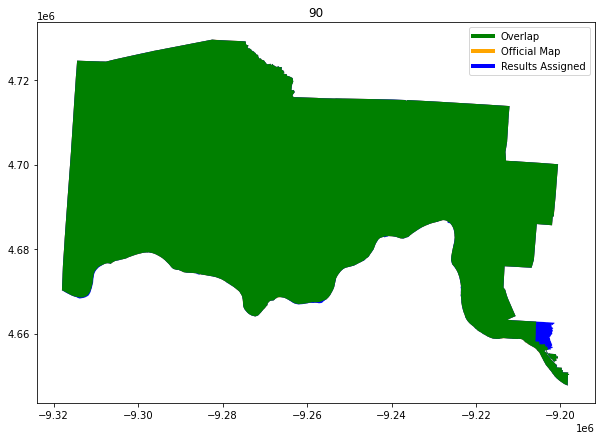

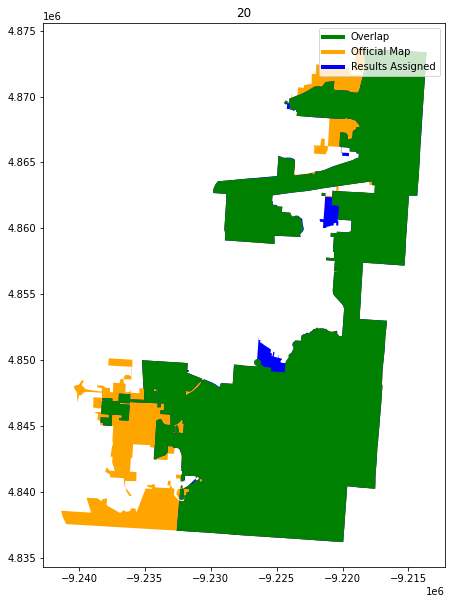

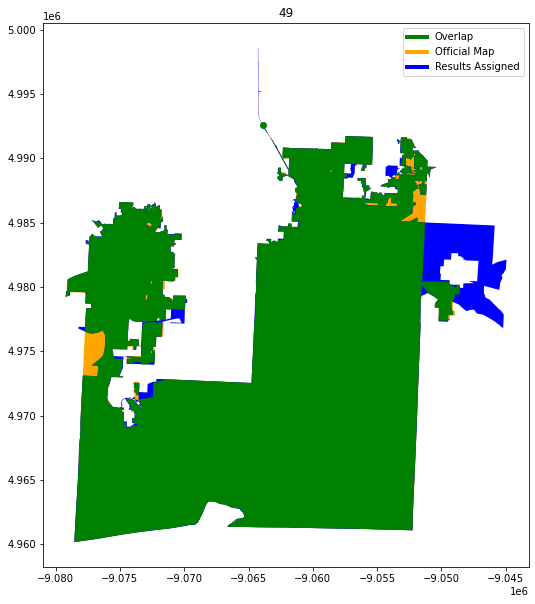

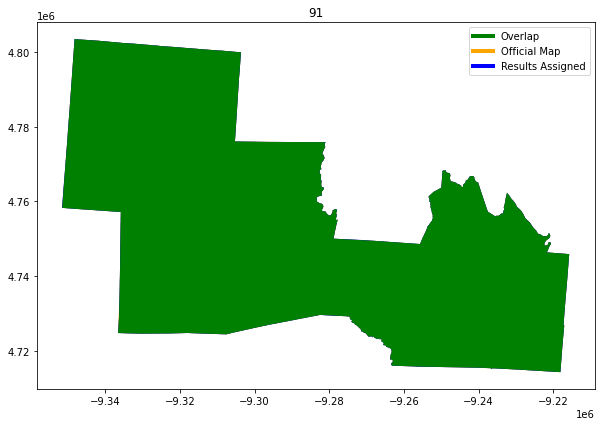

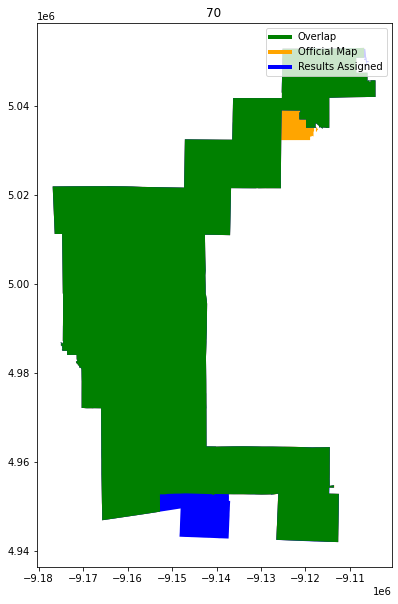

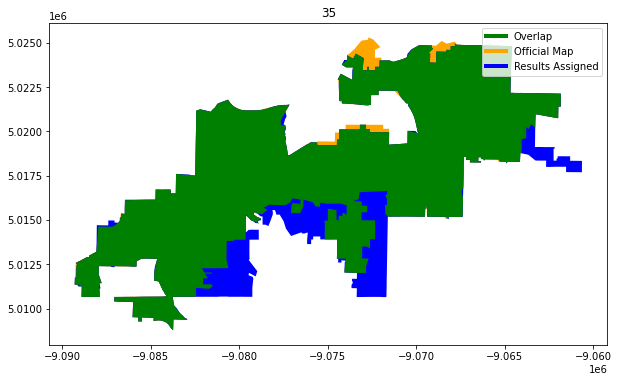

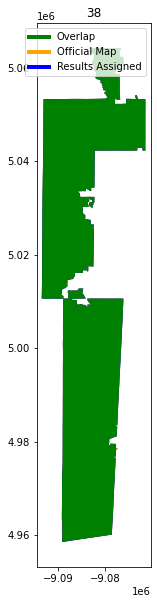

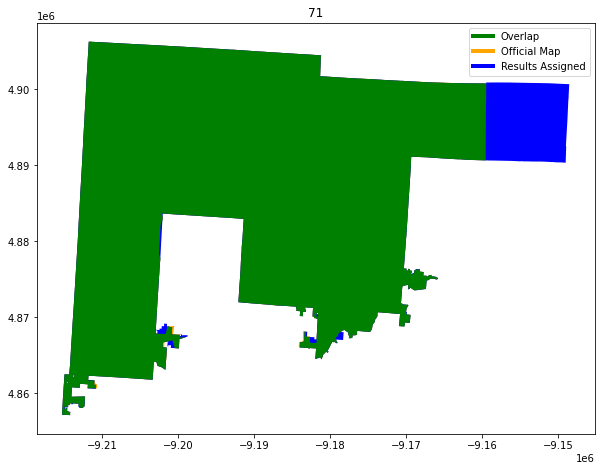

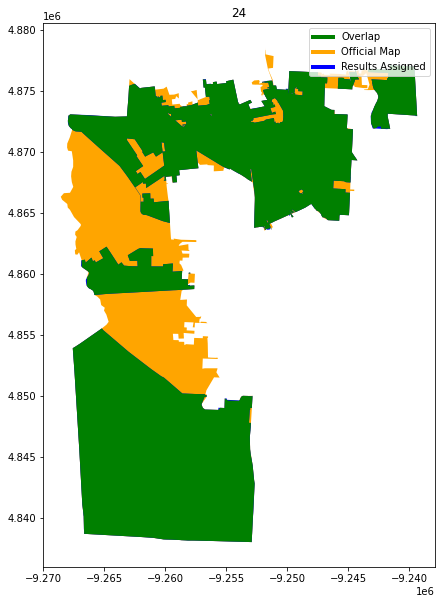

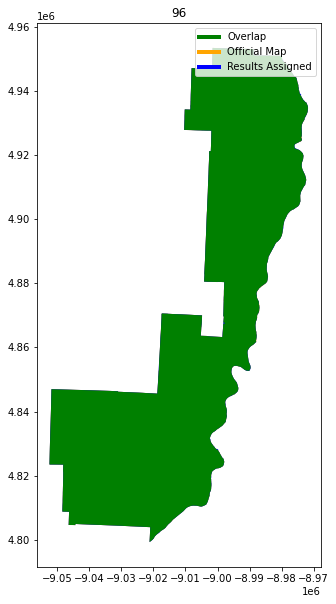

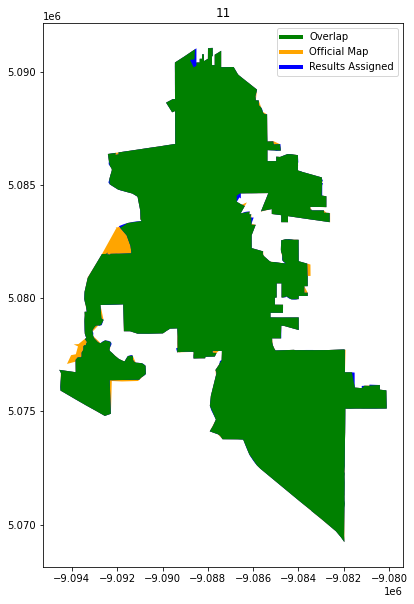

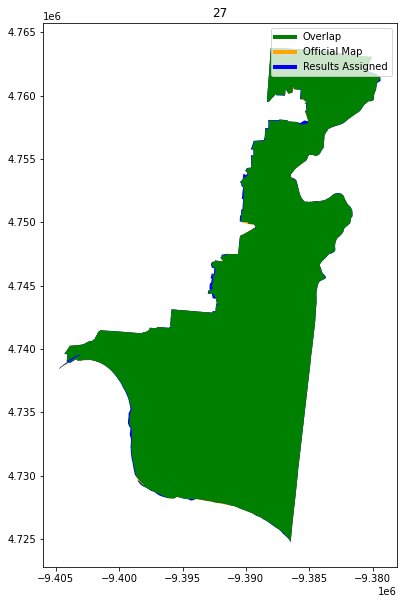

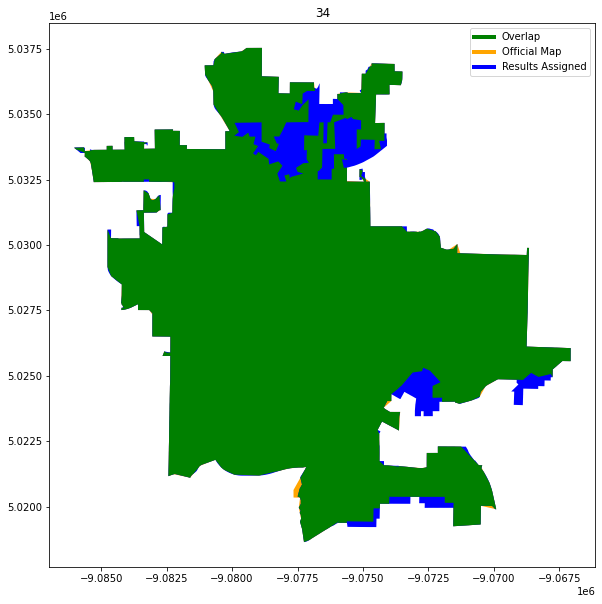

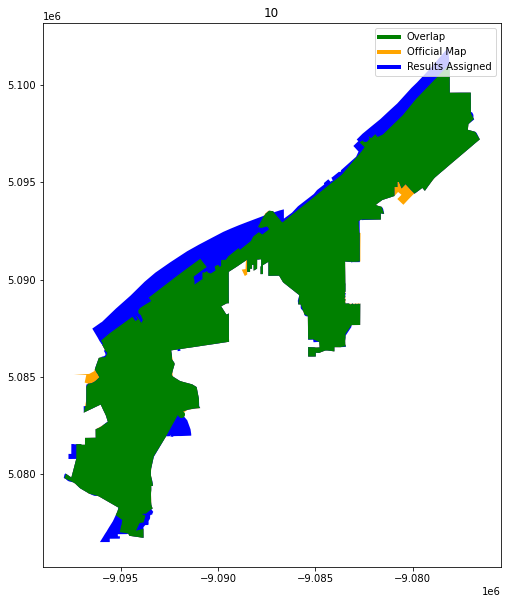

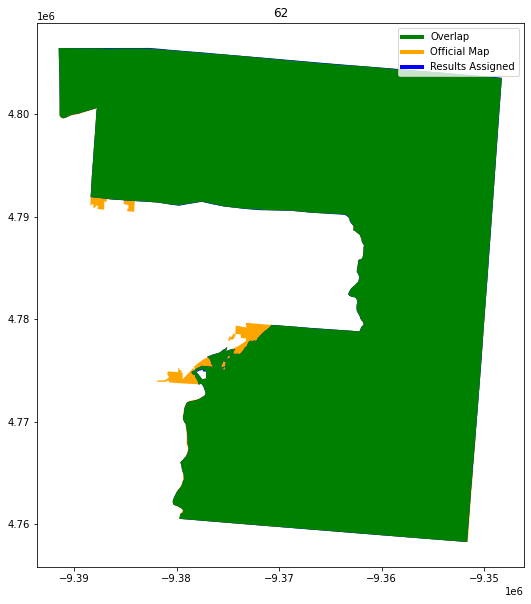

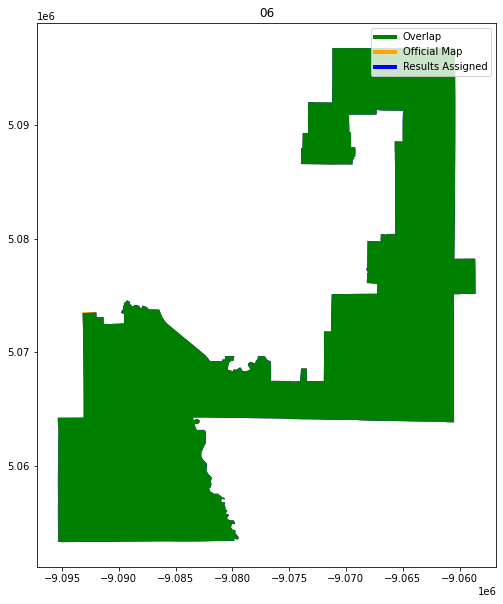

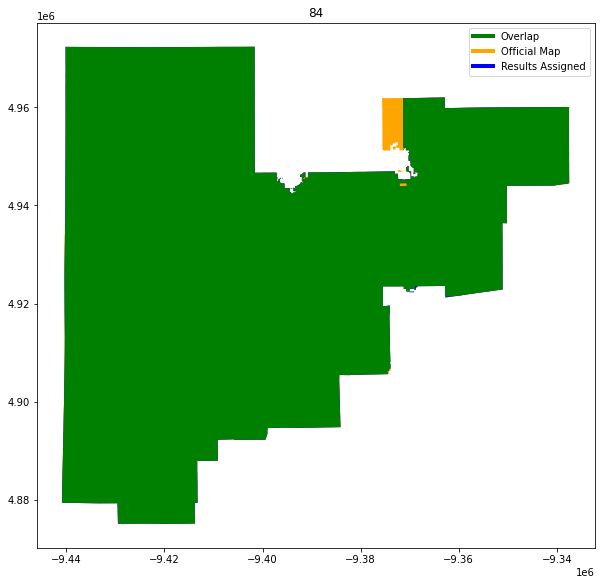

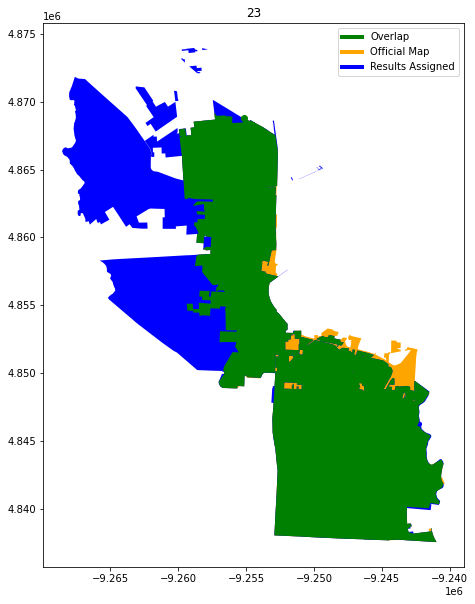

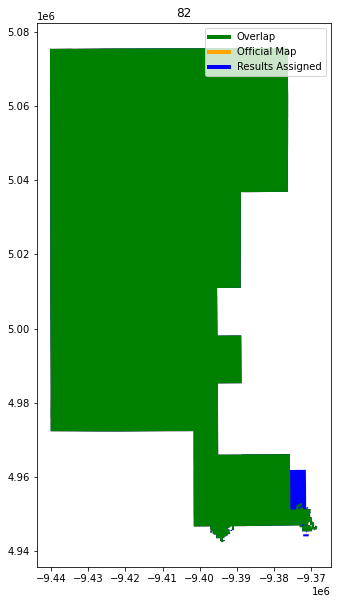

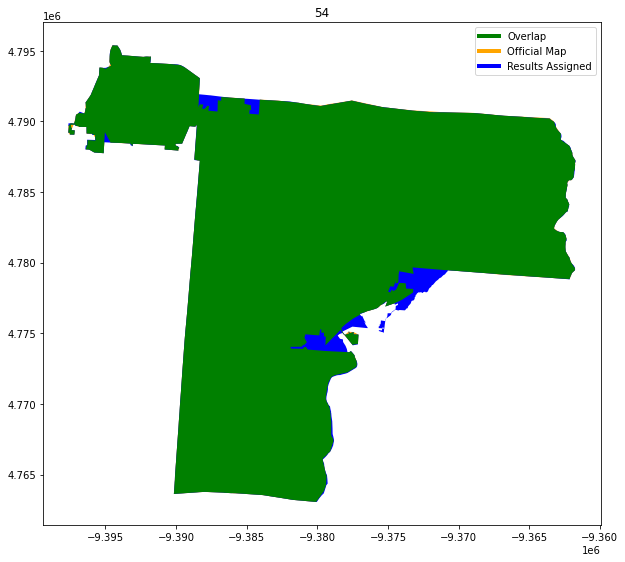

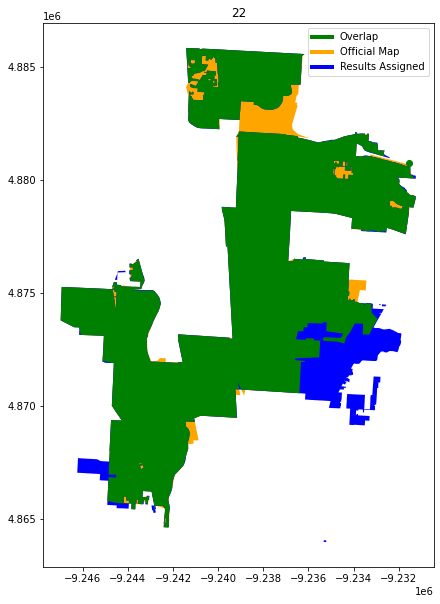

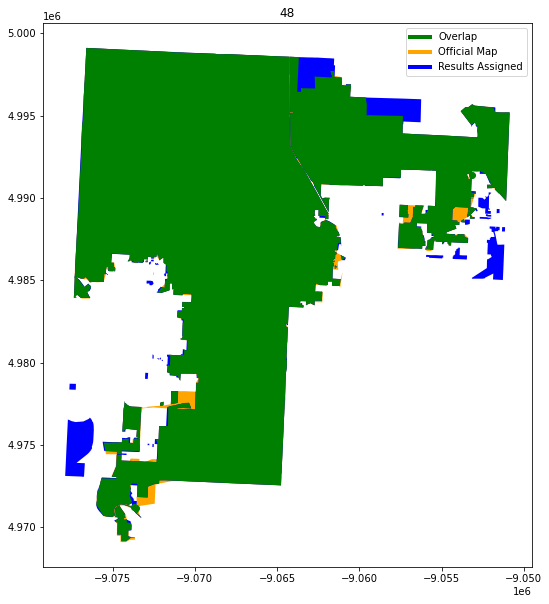

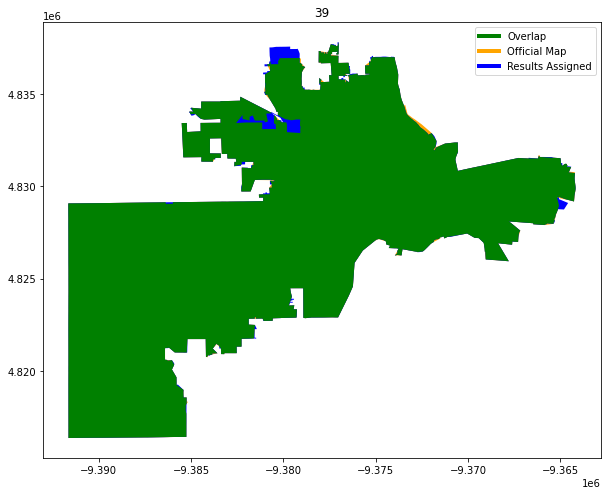

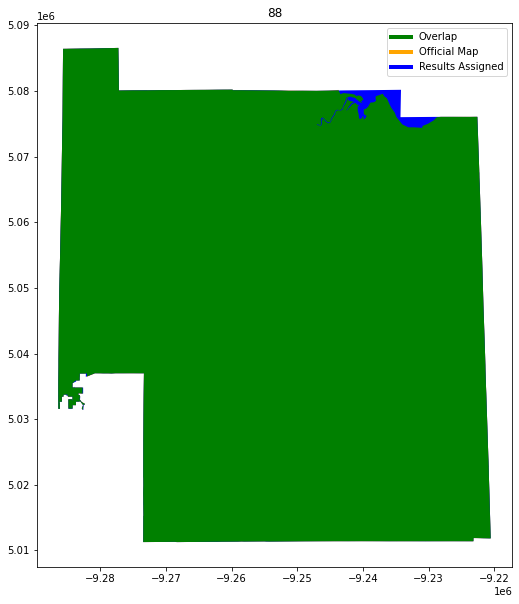

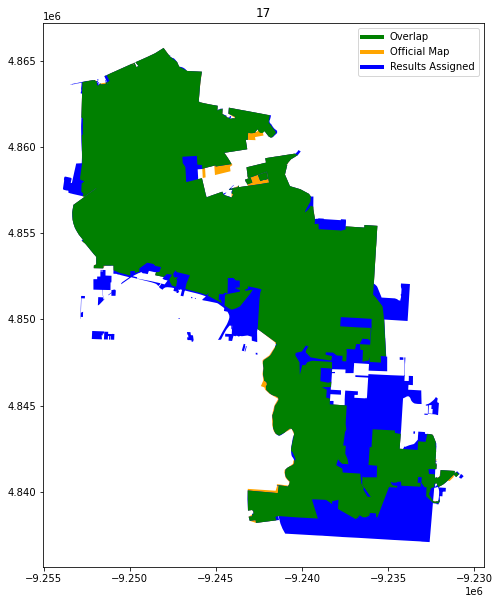

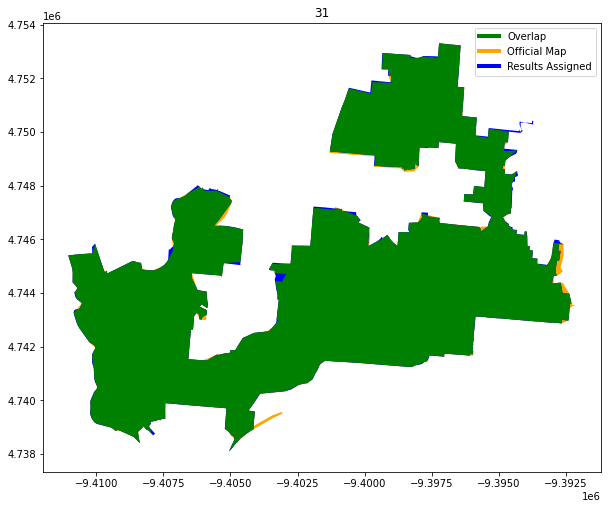

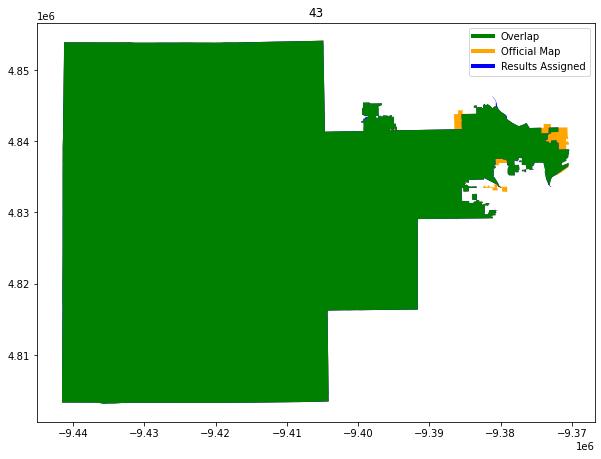

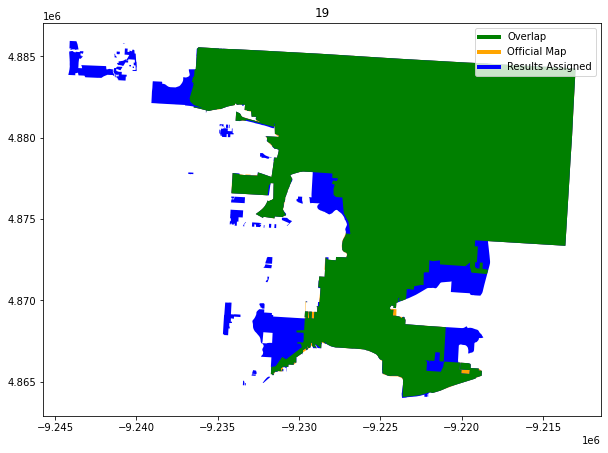

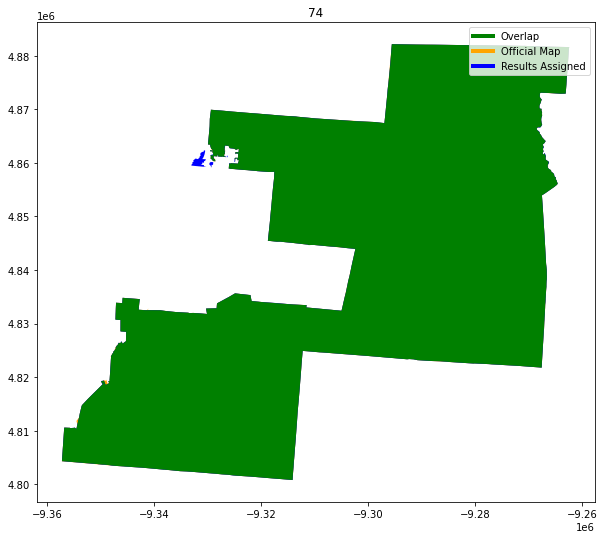

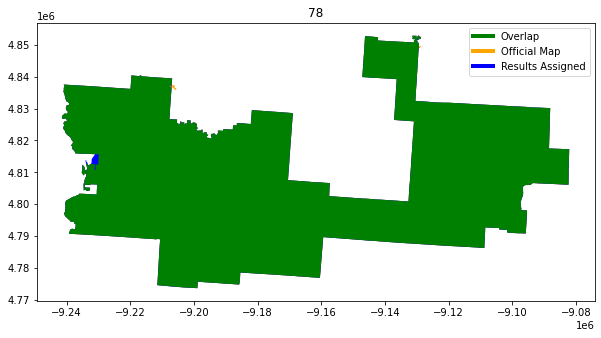

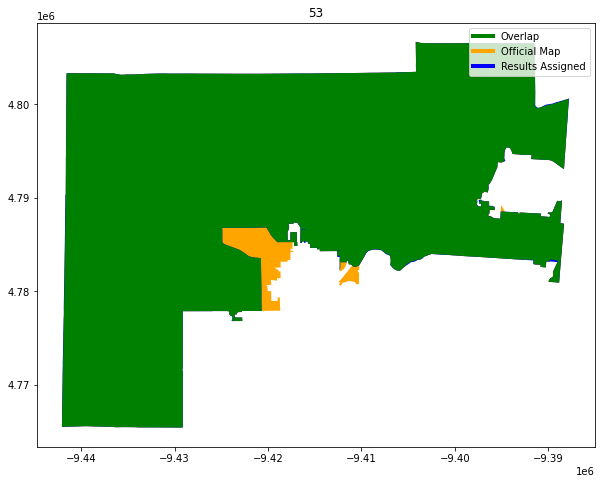

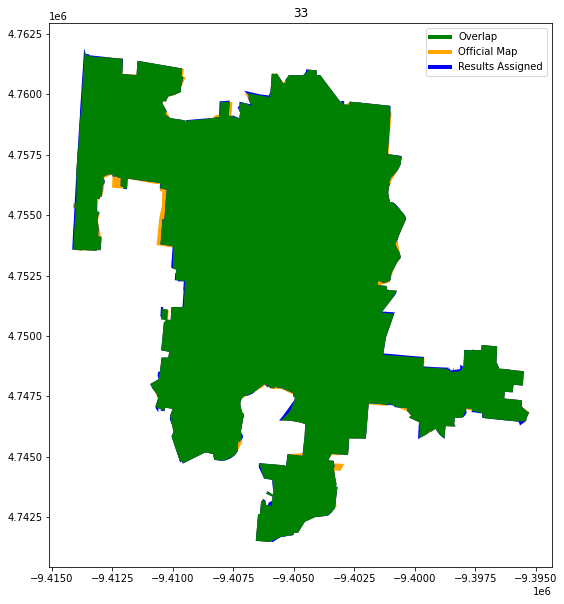

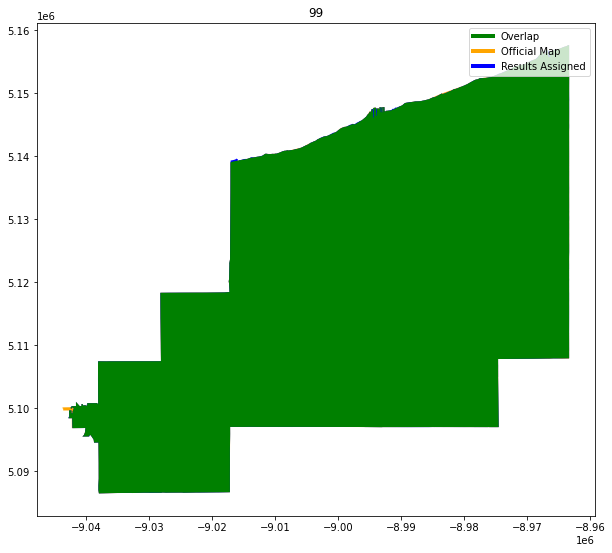

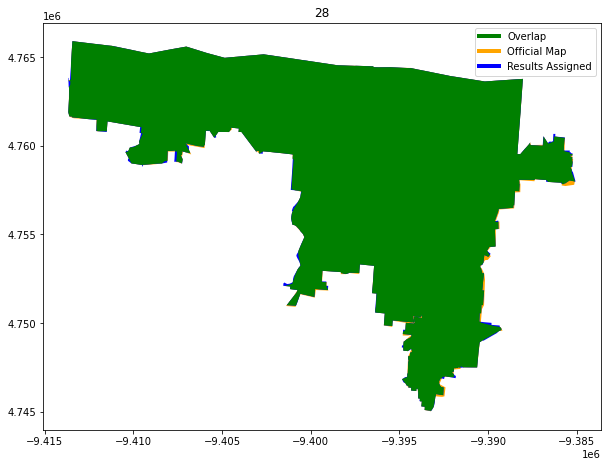

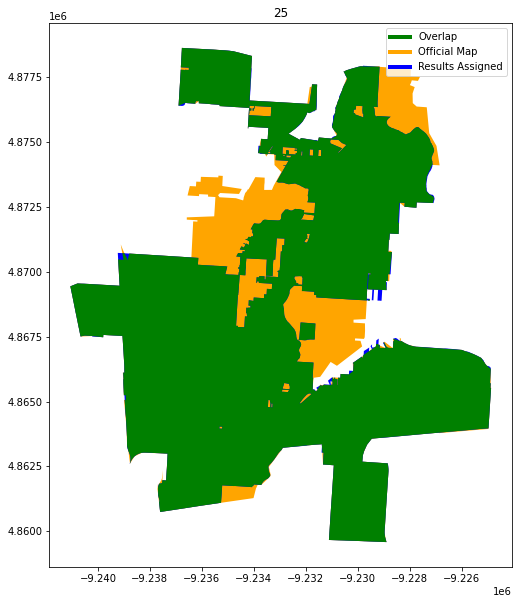

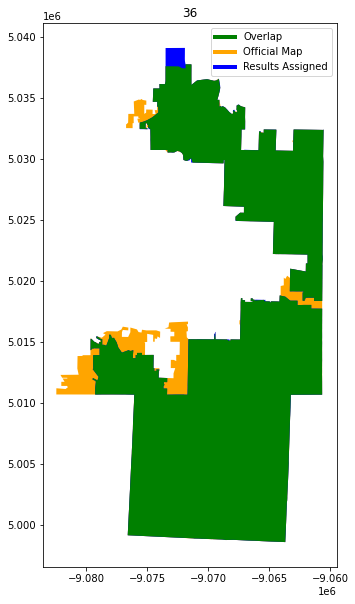

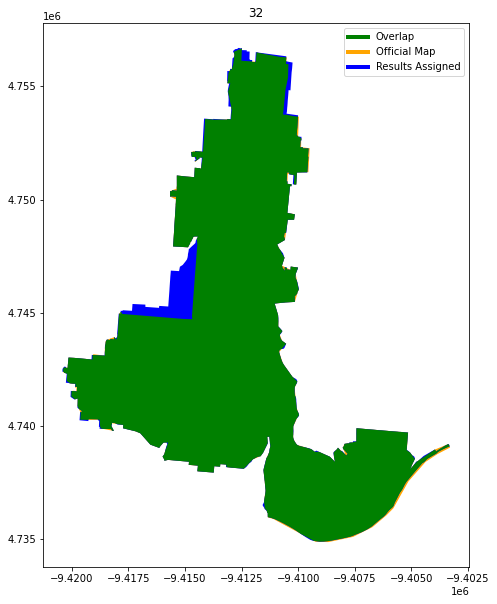

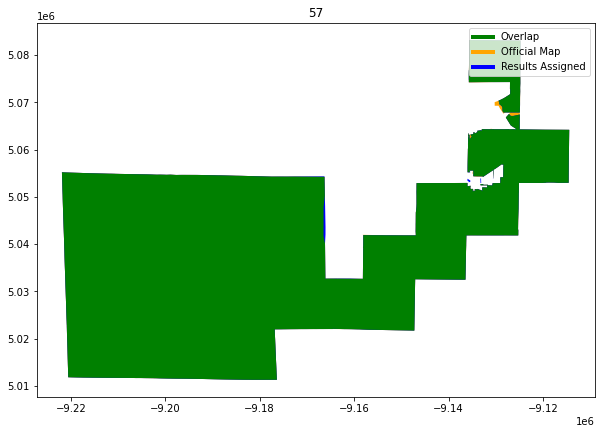

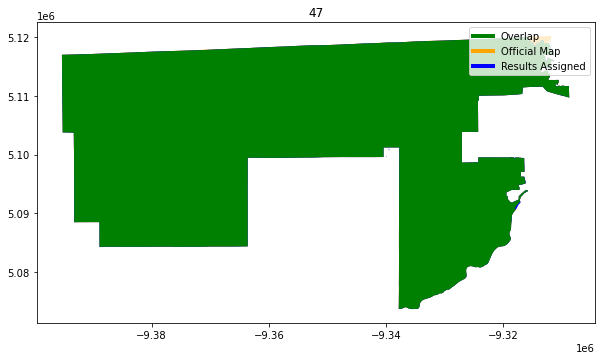

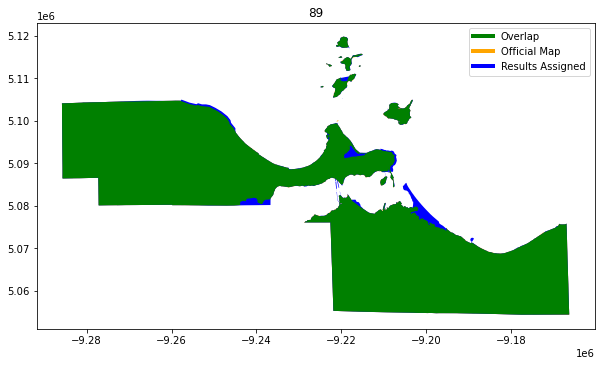

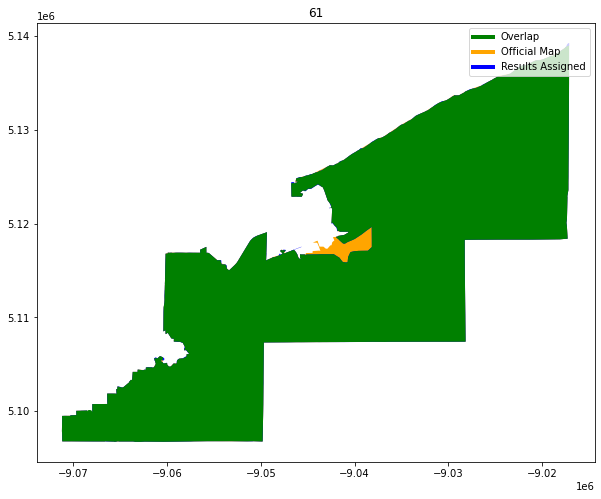

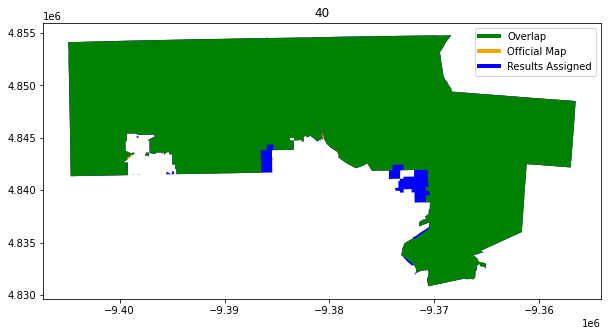

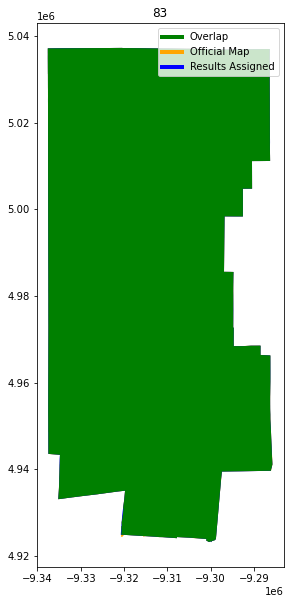

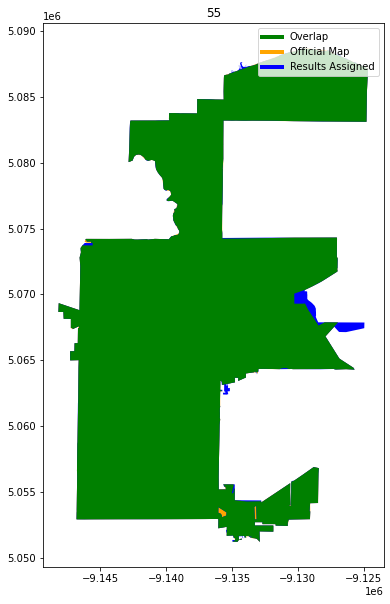

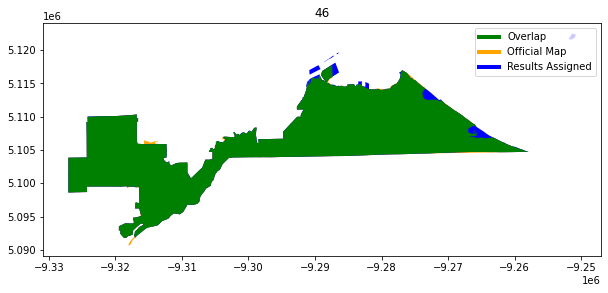

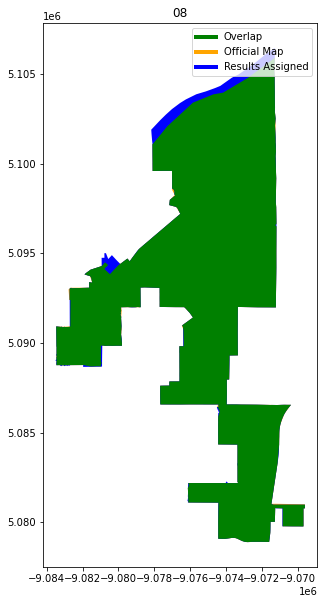

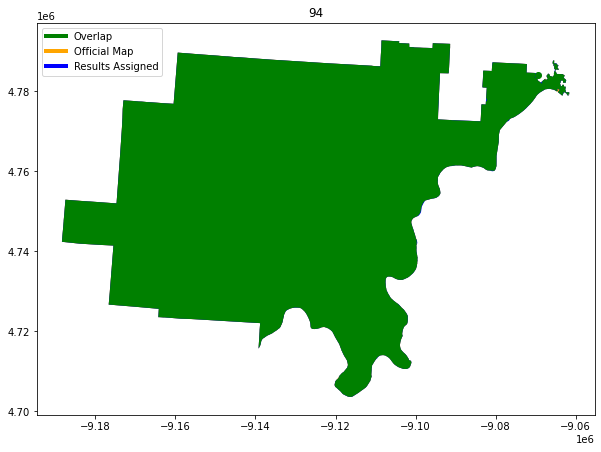

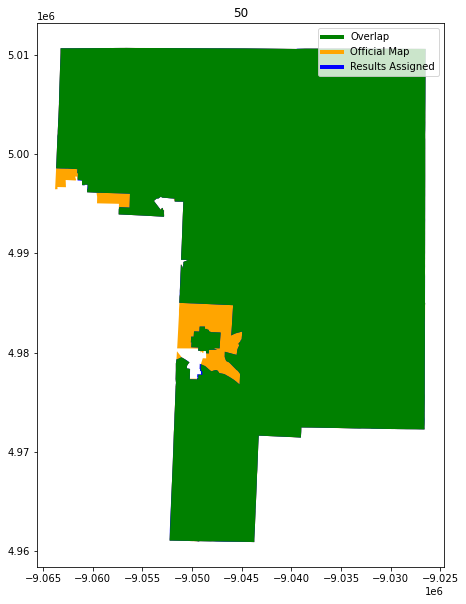

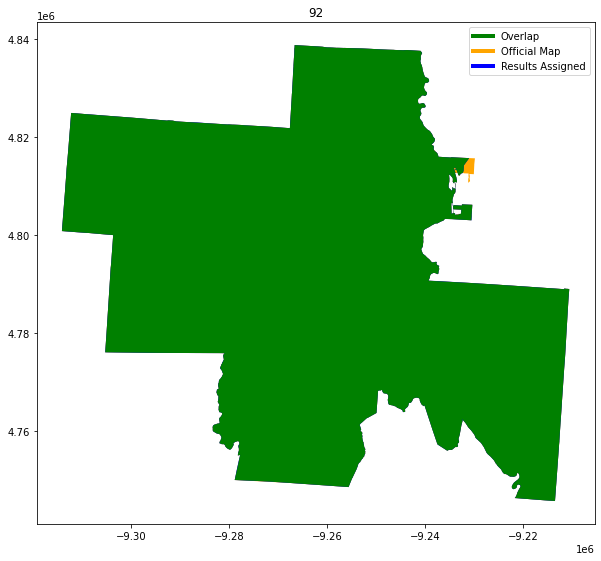

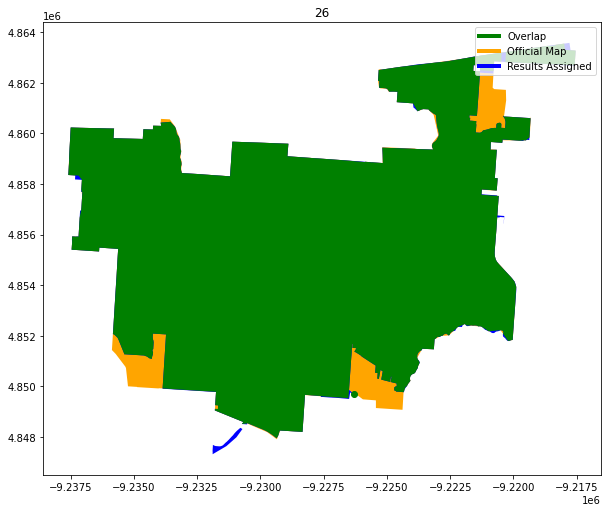

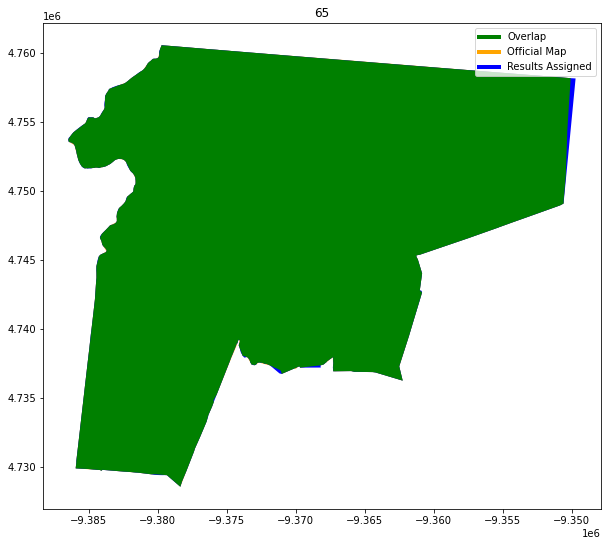

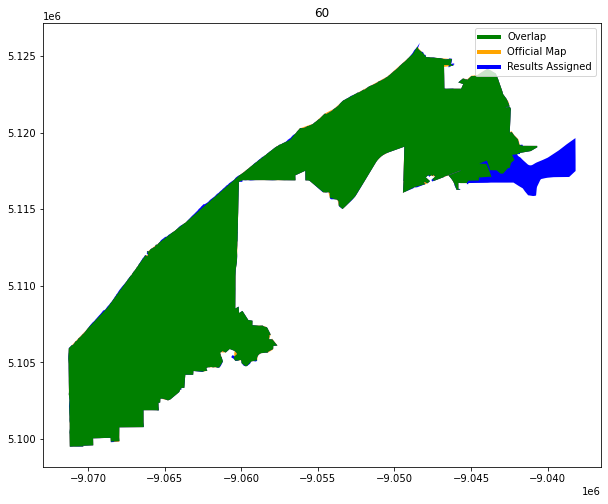

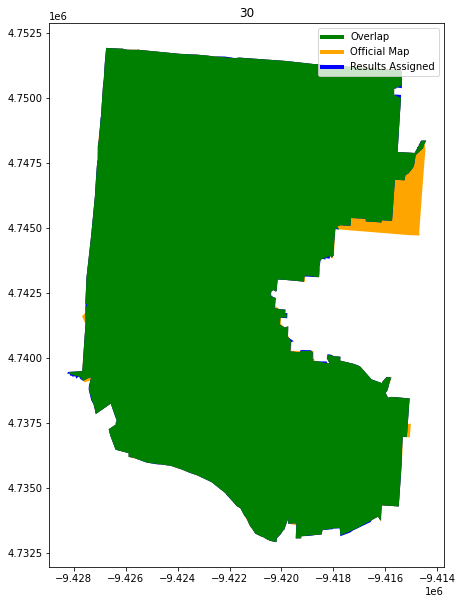

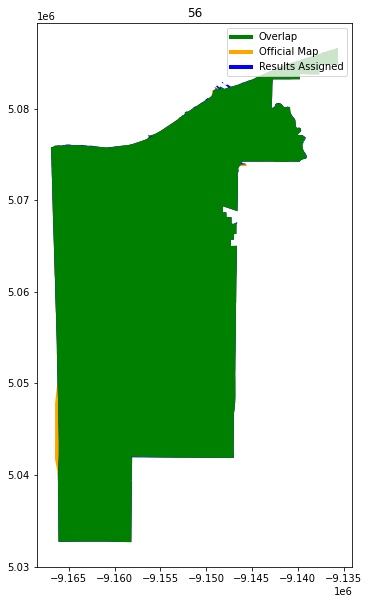

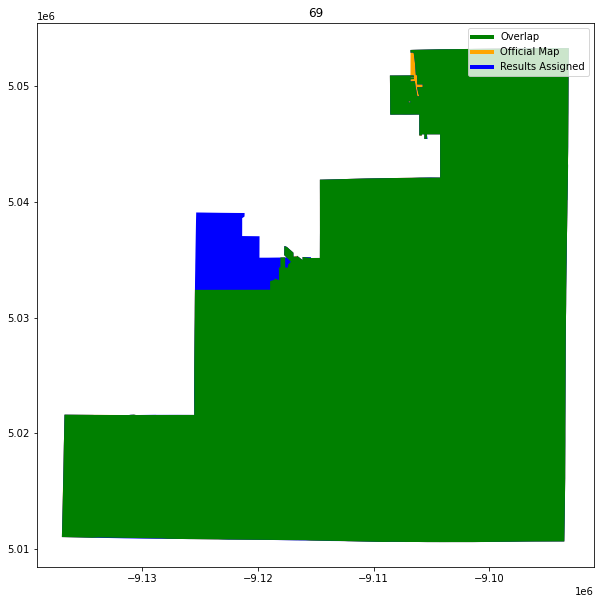

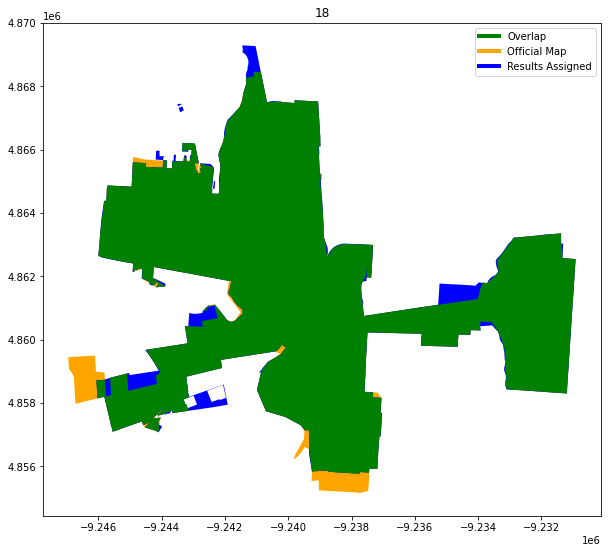

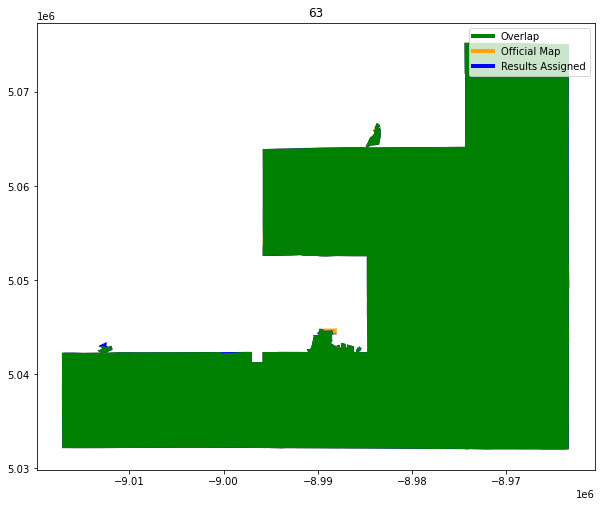

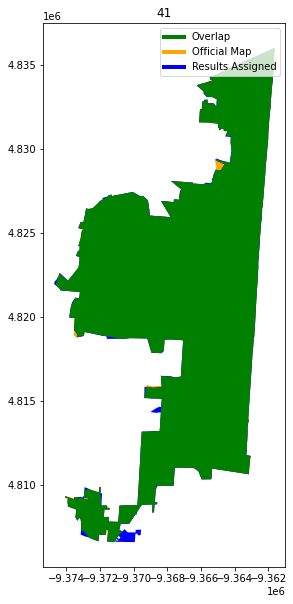

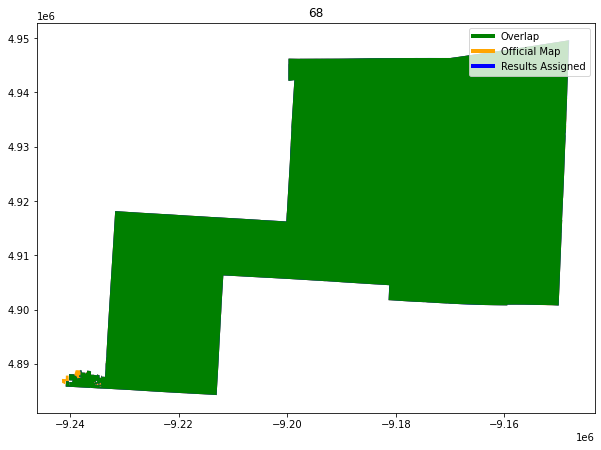

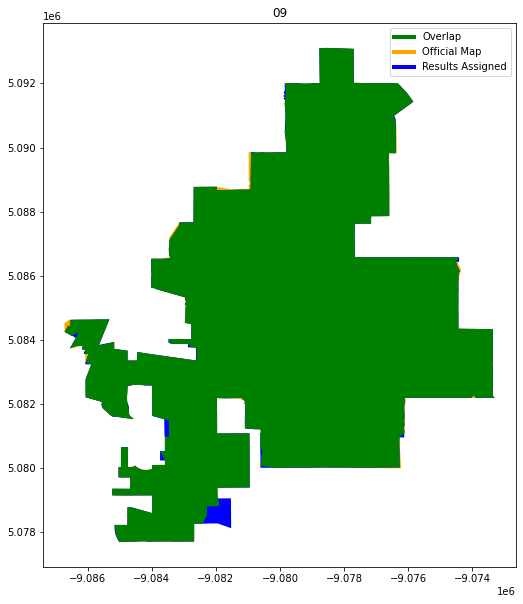

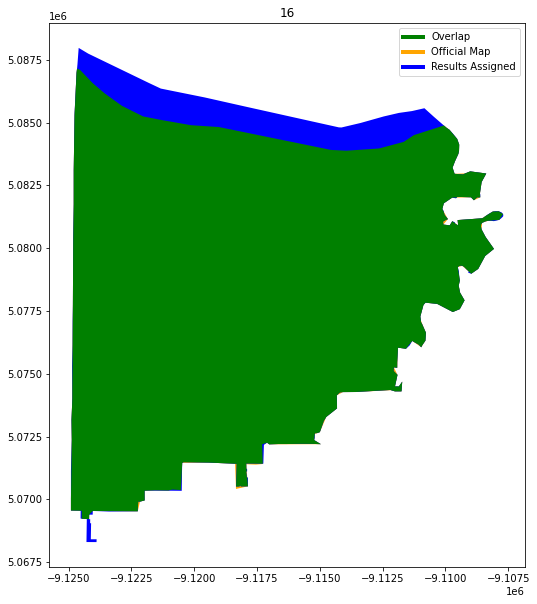

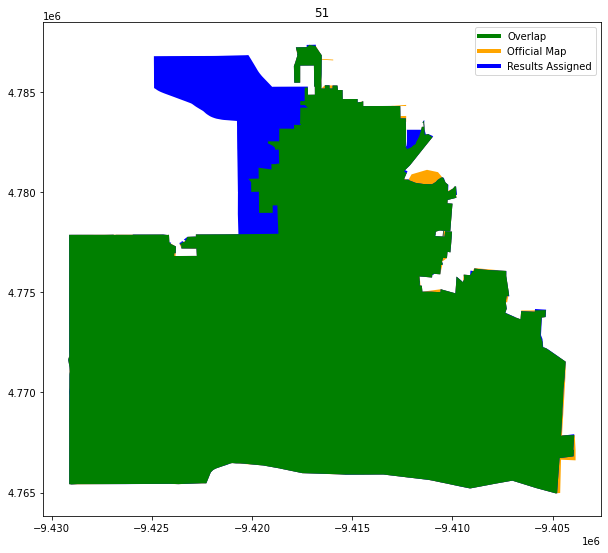

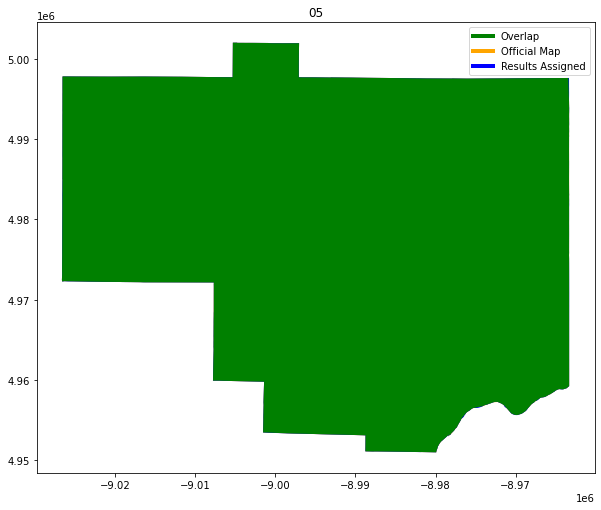

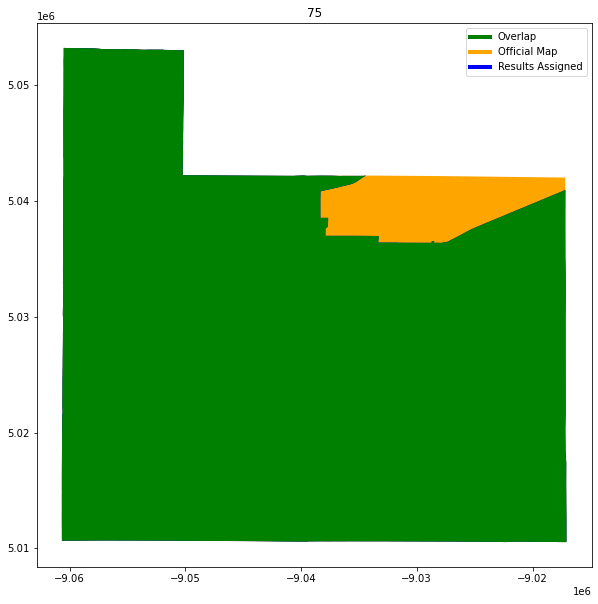

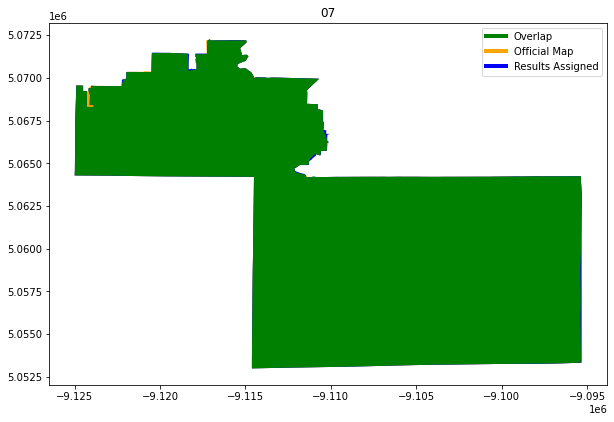

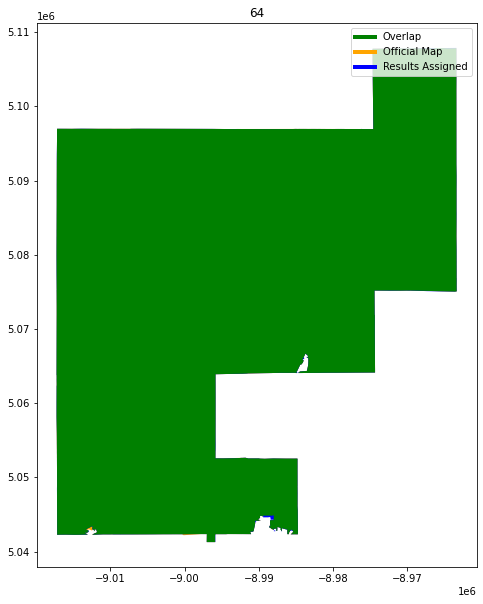

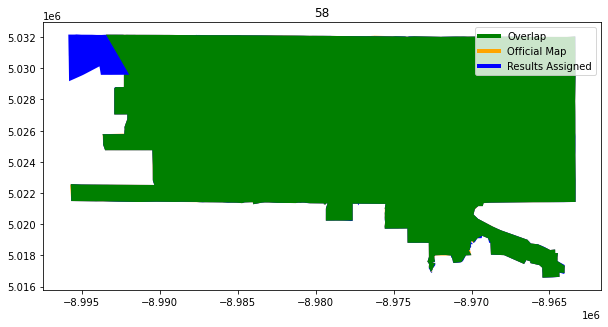

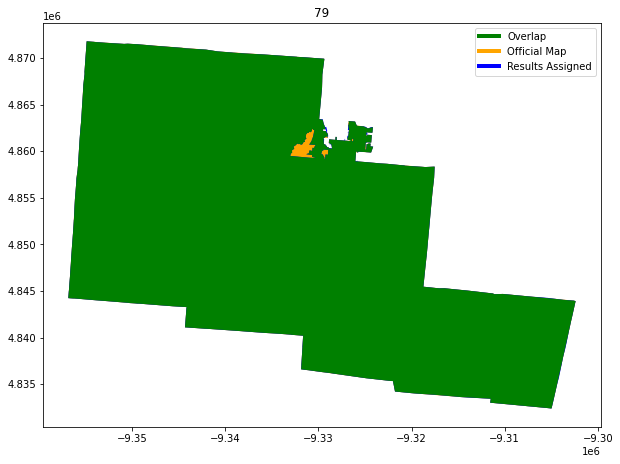

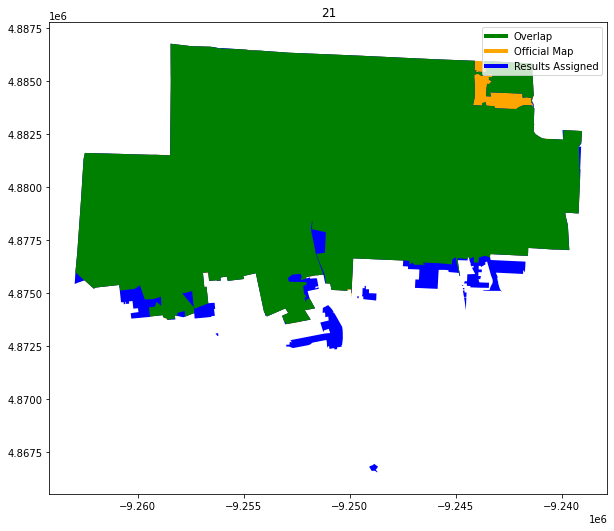

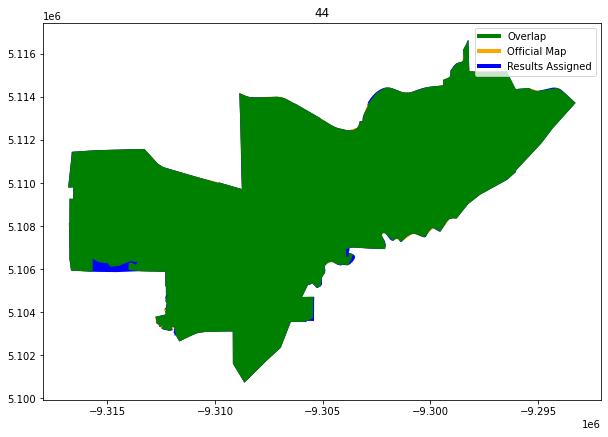

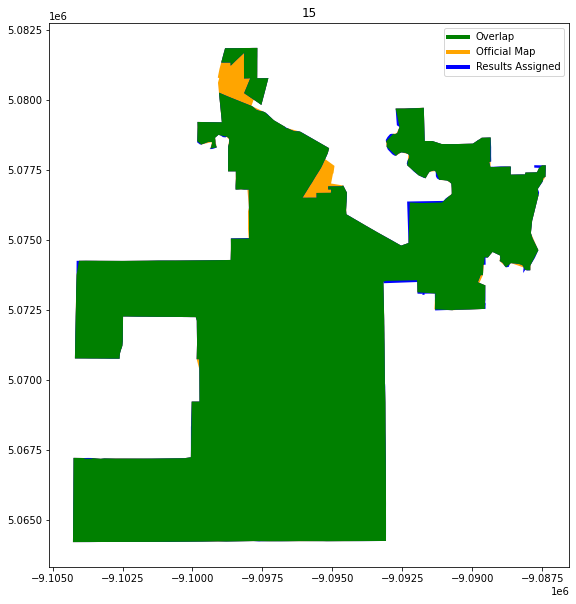

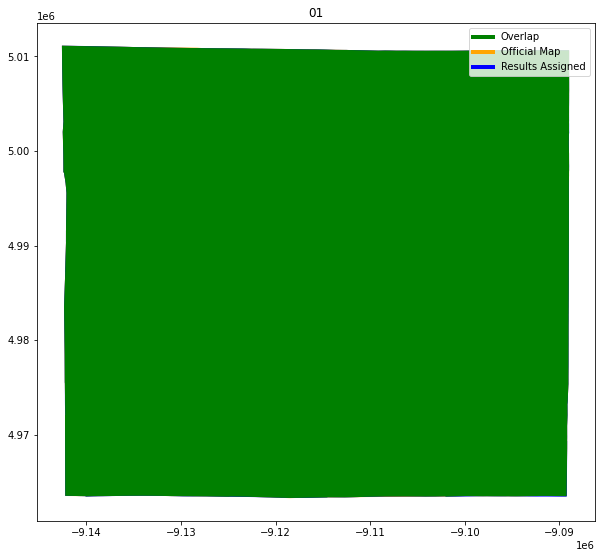

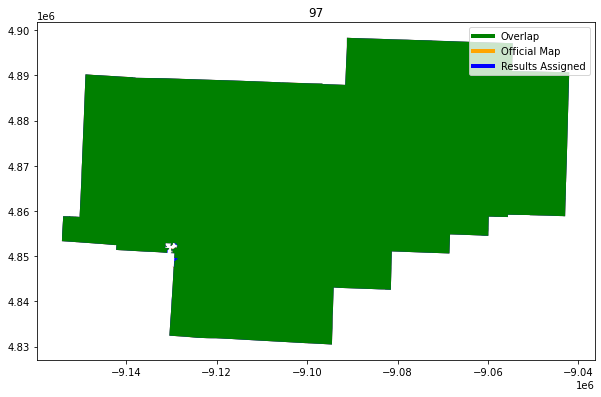

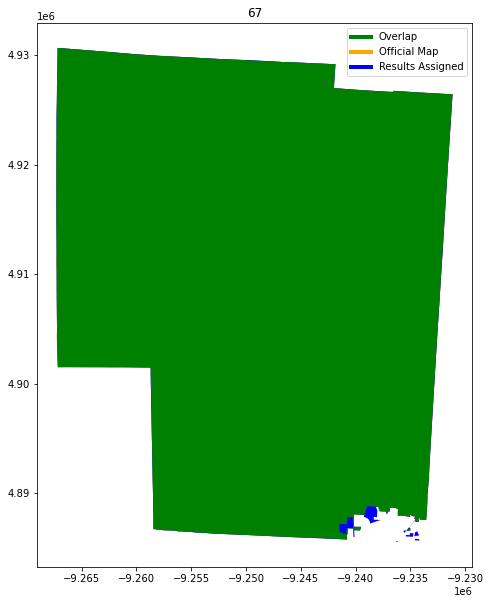

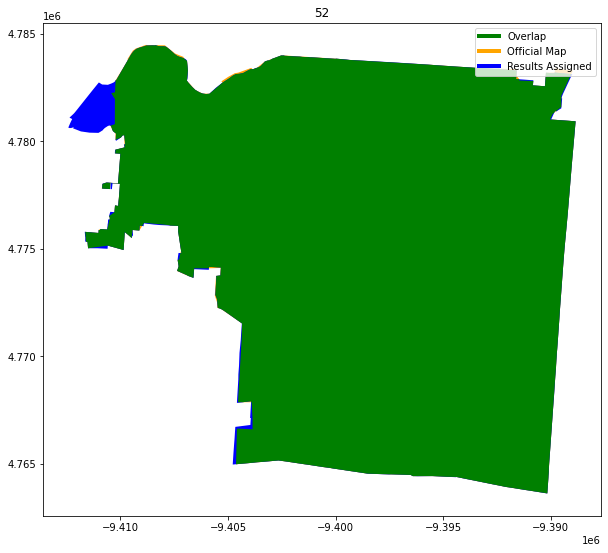

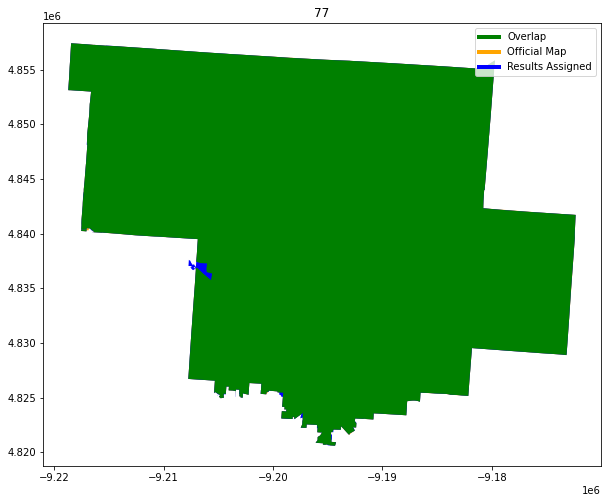

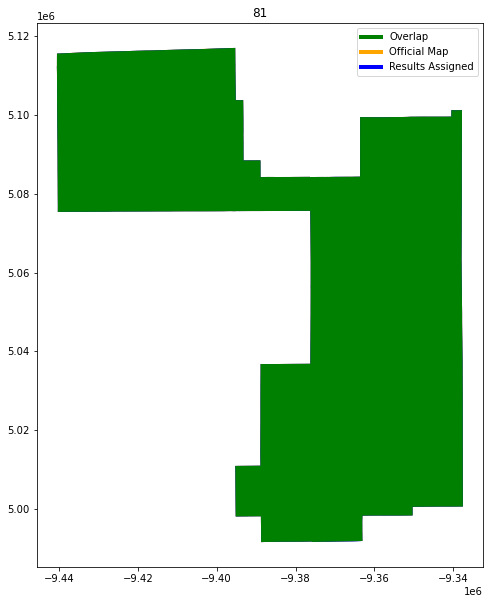

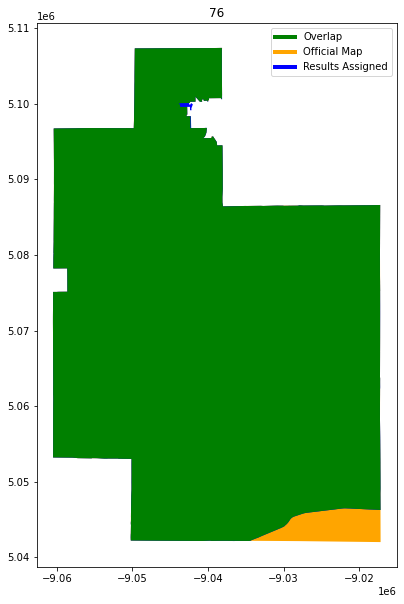

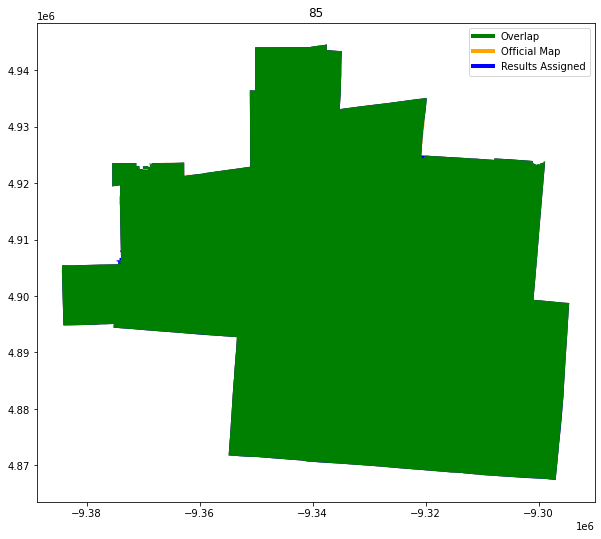

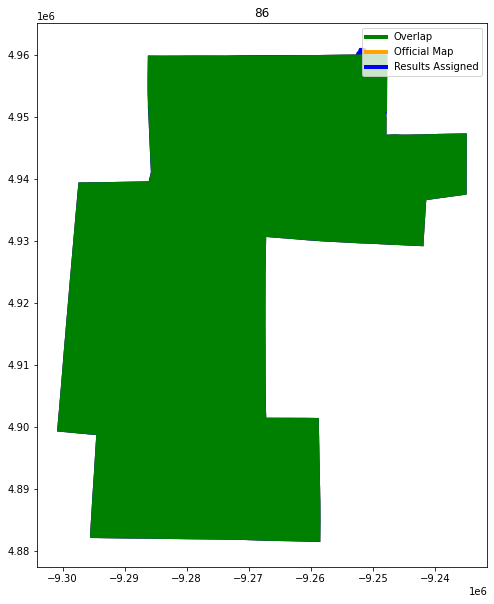

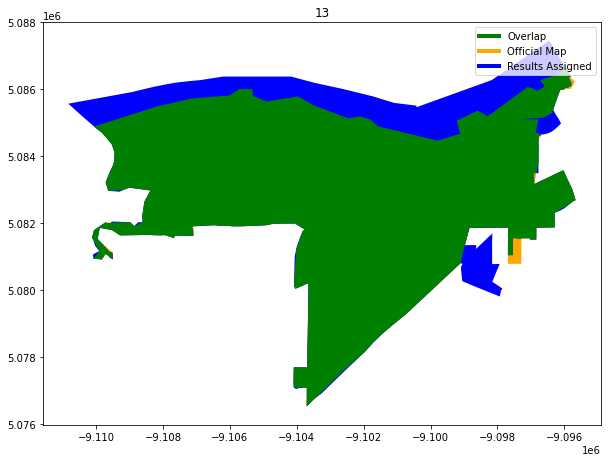

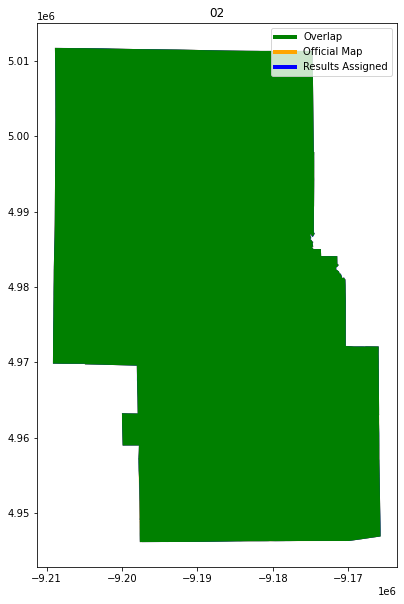

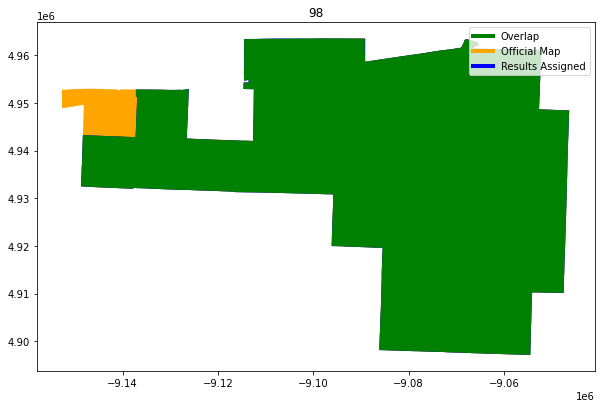

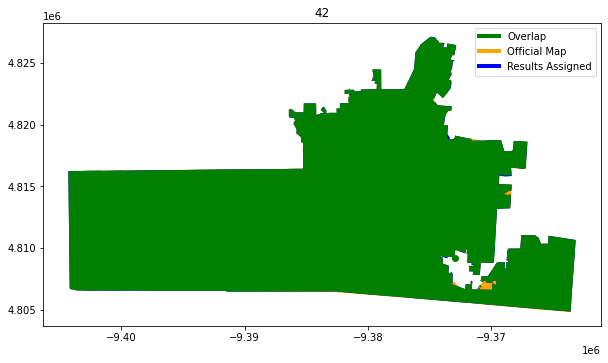

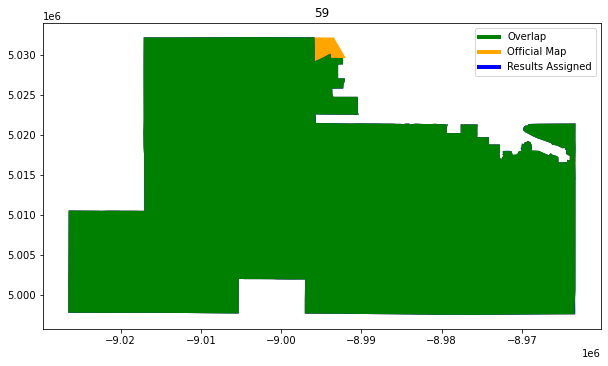

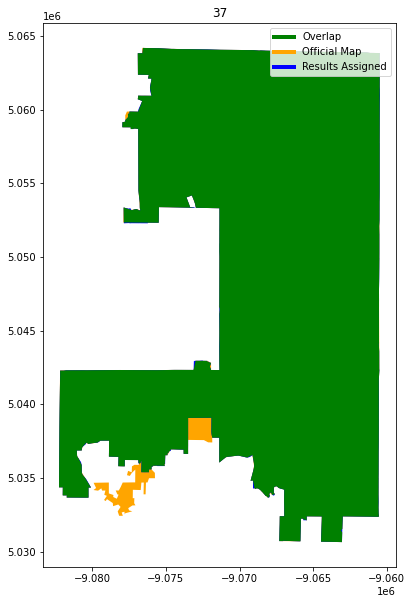

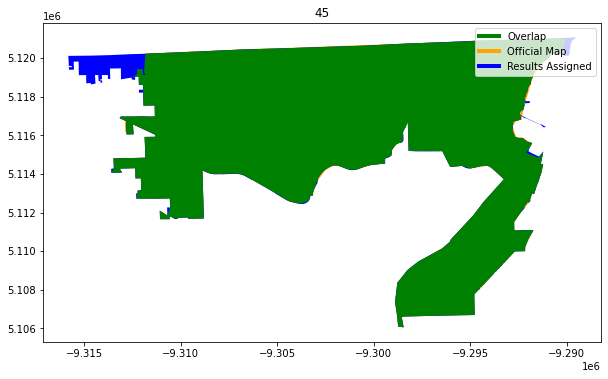

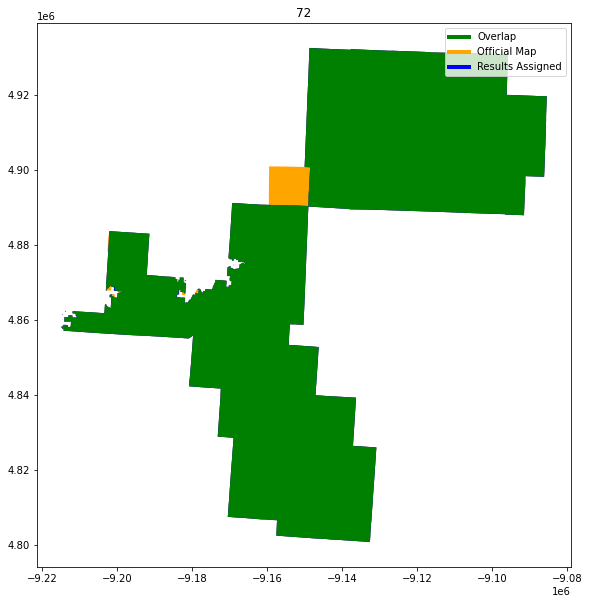

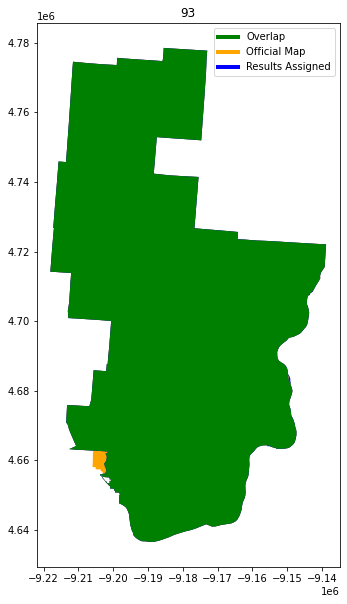

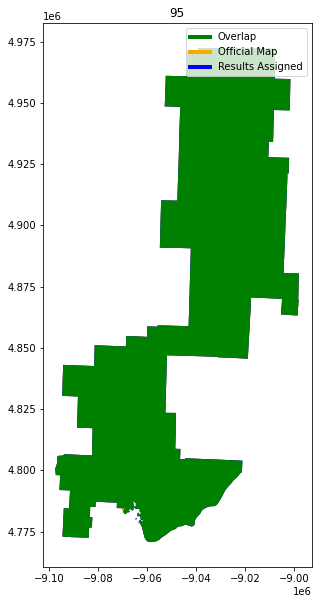

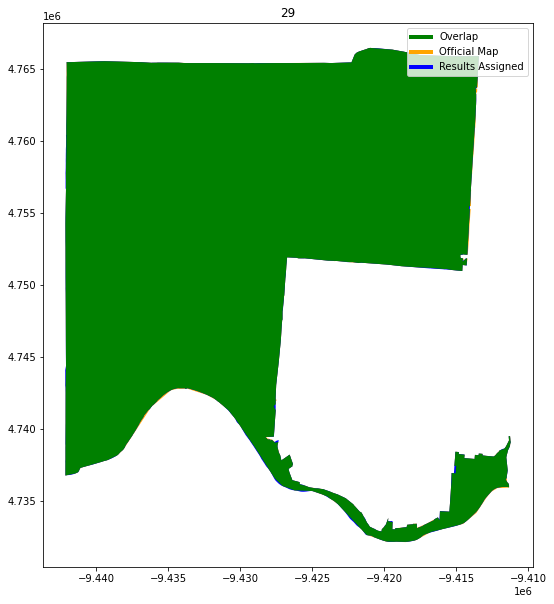

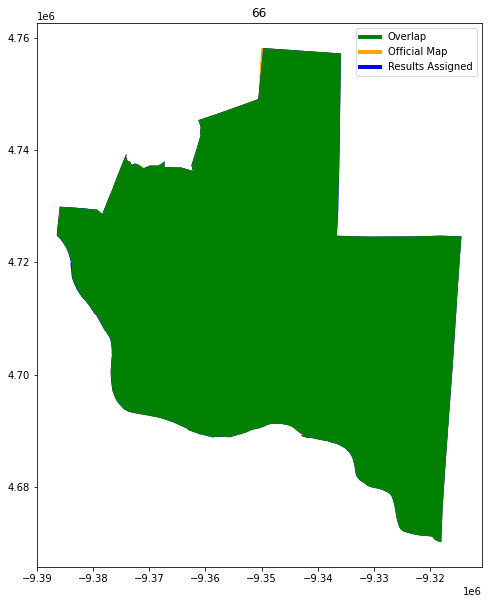

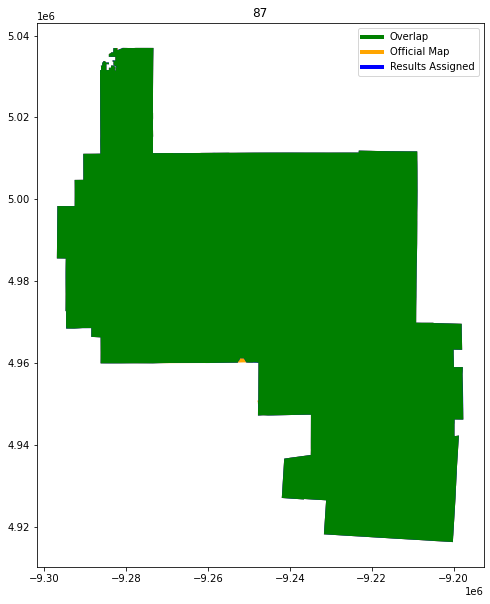

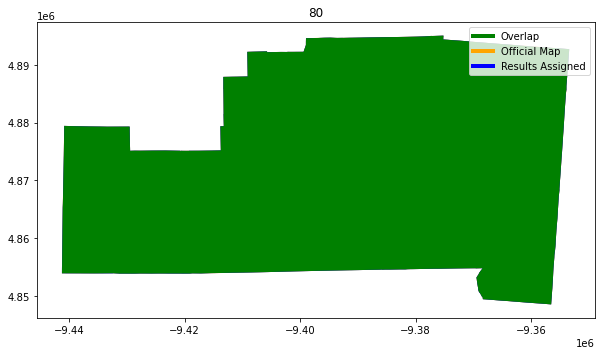

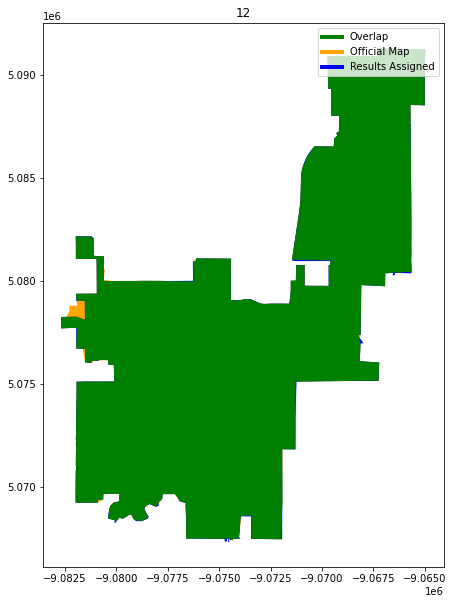

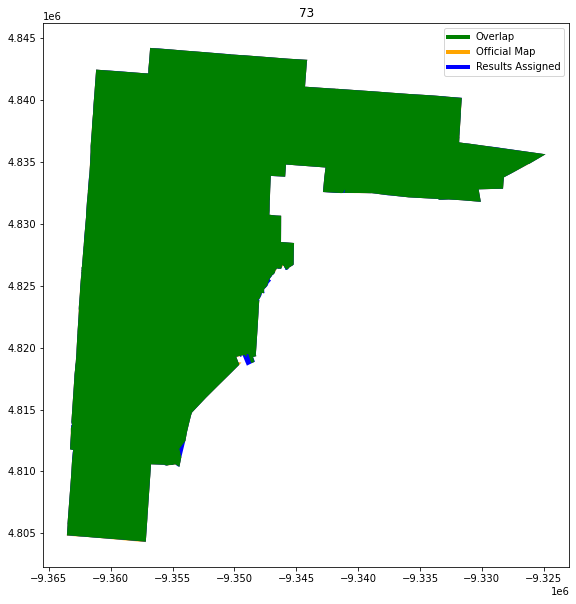

In [58]:
compare_geometries(oh_sll_districts,filtered_results,"Official Map","Results Assigned","SLDL_DIST",area_threshold=.1)

## Sort the columns to match what VEST has

In [59]:
vest_oh_20.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'geometry',
       'UNIQUE_ID'],
      dtype='object')

In [60]:
attempt_one.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20',
       'G20PRERTRU', 'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW',
       ...
       'GSL96LHER', 'GSL96DOLI', 'GSL97RHOL', 'GSL97DSWO', 'GSL98DBEE',
       'GSL98RHIL', 'GSL99DDAN', 'GSL99RART', 'Tot_Votes', 'SLDL_DIST'],
      dtype='object', length=200)

In [61]:
attempt_one.rename(columns={'Registered Voters':'REG_VOTERS'},inplace=True)

In [62]:
attempt_one = attempt_one[["UNIQUE_ID","COUNTYFP",'STATEFP20', 'COUNTYFP20', 'VTDST20', 'PRECINCT20', 'GEOID20', 'NAME20','SLDL_DIST']+
                         final_races+["geometry"]]

In [63]:
attempt_one.columns

Index(['UNIQUE_ID', 'COUNTYFP', 'STATEFP20', 'COUNTYFP20', 'VTDST20',
       'PRECINCT20', 'GEOID20', 'NAME20', 'SLDL_DIST', 'GSL01DTHE',
       ...
       'GSL96RFER', 'GSL96LHER', 'GSL96DOLI', 'GSL97RHOL', 'GSL97DSWO',
       'GSL98DBEE', 'GSL98RHIL', 'GSL99DDAN', 'GSL99RART', 'geometry'],
      dtype='object', length=187)

In [64]:
if not os.path.exists('./oh_gen_20_prec/'):
    os.mkdir('./oh_gen_20_prec/')

attempt_one.to_file('./oh_gen_20_prec/oh_gen_20_sldl_prec.shp')